## Track the plasma motion

Cite this GitHub url: https://github.com/hayesla/DynaSun_workshop/blob/main/sunpy_dynasun_tutorial.ipynb

In [755]:
import warnings
warnings.filterwarnings('ignore')

import glob
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import sunpy.map
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import Normalize, LogNorm
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from astropy.visualization import ImageNormalize, SqrtStretch, LogStretch, AsymmetricPercentileInterval, AsinhStretch
import astropy.units as u
from astropy.coordinates import SkyCoord, SkyOffsetFrame
from scipy.interpolate import interp1d
from sunpy.coordinates import SphericalScreen
from scipy.stats import linregress
from sunpy.sun import constants as const
from tqdm import tqdm

import os
import sys
# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
if script_path not in sys.path:
    sys.path.append(script_path)

import solar_data_utils as myfuncs
# Reload to update with new changes
import importlib
importlib.reload(myfuncs)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

import matplotlib
import sunpy.visualization.colormaps as cm

sdoaia171 = matplotlib.colormaps['sdoaia171']
sdoaia193 = matplotlib.colormaps['sdoaia193']
sdoaia211 = matplotlib.colormaps['sdoaia211']
sdoaia304 = matplotlib.colormaps['sdoaia304']

data_dir = '/home/mnedal/data'

In [2]:
dict_maps = {
    '171A': [],
    '193A': [],
    '211A': [],
    '304A': []
}

# AIA 304 &Aring;

In [3]:
start = '2024-05-14T17:00:00'
end   = '2024-05-14T18:59:00'
channel = 304
data_type = 'highres'

# Check if the datetime is a string
if isinstance(start, str) and isinstance(end, str):
    dt_dict = myfuncs.split_datetime(start=start, end=end)

# Check if the datetime is a pandas.Timestamp
elif isinstance(start, pd.Timestamp) and isinstance(end, pd.Timestamp):
    dt_dict = myfuncs.split_datetime(start=str(start).replace(' ','T'), end=str(end).replace(' ','T'))

data_path = f'{data_dir}/AIA/{channel}A/{data_type}/lv15'
data = sorted(glob.glob(f'{data_path}/aia*{channel}A_*.fits'))

start_pattern = f"aia*{channel}A_{dt_dict['start_year']}_{dt_dict['start_month']}_{dt_dict['start_day']}T{dt_dict['start_hour']}_{dt_dict['start_minute']}*"
end_pattern   = f"aia*{channel}A_{dt_dict['end_year']}_{dt_dict['end_month']}_{dt_dict['end_day']}T{dt_dict['end_hour']}_{dt_dict['end_minute']}*"

first_file_to_find = sorted(glob.glob(f'{data_path}/{start_pattern}*.fits'))
last_file_to_find  = sorted(glob.glob(f'{data_path}/{end_pattern}*.fits'))

idx1 = data.index(first_file_to_find[0])
idx2 = data.index(last_file_to_find[0])

chosen_files = data[idx1:idx2]

map_objects = []
with tqdm(total=len(chosen_files), desc='Loading the maps ...') as pbar:
    for i, file in enumerate(chosen_files):
        # load the file as a sunpy map
        m = sunpy.map.Map(file)
        map_objects.append(m)
        pbar.update(1)

Loading the maps ...: 100%|█████████████████████████████████████████| 592/592 [01:36<00:00,  6.15it/s]


In [4]:
len(map_objects), map_objects[0].meta['t_obs'], map_objects[-1].meta['t_obs']

(592, '2024-05-14T17:00:06.59Z', '2024-05-14T18:58:54.58Z')

In [5]:
dict_maps['304A'] = map_objects

In [ ]:
idx = 177
m = map_objects[idx]
norm = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch()) # SqrtStretch, LogStretch, AsinhStretch

# crop the region of interest
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)

In [8]:
# # take the slit coordinates and maps them onto the pixel grid of the solar image
# slit_pixelated = sunpy.map.pixelate_coord_path(m, slit)

# # how far the slit extends in terms of physical distance on the map
# slit_distance = slit_pixelated.separation(slit_pixelated[0])

In [9]:
# # track how intensity evolves along the slit over the sequence of solar images
# for m in map_objects:
#     m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch())

# intensity_stack = []
# with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
#     for m in map_objects:
#         with SphericalScreen(m.observer_coordinate):
#             slit_pixelated = sunpy.map.pixelate_coord_path(m, slit)
#         slit_distance = slit_pixelated.separation(_slit_pixelated[0])
#         intensity = sunpy.map.sample_at_coords(m, _slit_pixelated)
#         f_interp = interp1d(slit_distance.to_value('arcsec'), intensity.value, fill_value='extrapolate', kind='linear')
#         intensity_interp = f_interp(slit_distance.to_value('arcsec'))
#         intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
#         pbar.update(1)

# # intensity_stack = u.Quantity(intensity_stack)

# # get the time array and the distance along slit in arcsec
# time_array = [m.date.datetime for m in map_objects]
# distance = slit_distance.to(u.arcsec)

In [10]:
# fig, ax = plt.subplots(figsize=[15,5])
# ax.pcolormesh(time_array, distance.value, np.array(intensity_stack).T,
#               norm=ImageNormalize(stretch=AsinhStretch()),
#               cmap=sdoaia304
#              )
# ax.text(0.985, 0.95, 'Slit 1', transform=ax.transAxes,
#         fontsize=15, color='white', verticalalignment='top', horizontalalignment='right',
#         # bbox=dict(facecolor='white', alpha=0.5)
#        )
# ax.set_ylabel('Distance along slit (arcsec)')
# ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
# fig.tight_layout()
# plt.show()

In [ ]:
start_time = datetime(2024, 5, 14, 17, 18, 0)    # Replace with your actual start time
end_time   = datetime(2024, 5, 14, 17, 48, 0)    # Replace with your actual end time
start_distance = 17.5                            # Replace with your actual start distance
end_distance = 0.5                               # Replace with your actual end distance

# get the radius of the solar disk
sol_rad = const.equatorial_radius.to(u.km)

# conversion factor from arcsec to km
conversion_factor = sol_rad/m_run.rsun_obs
print(conversion_factor)

# Convert datetime to numerical format (Matplotlib date format)
start_num = mdates.date2num(start_time)
end_num = mdates.date2num(end_time)

# Perform linear fit
slope, intercept, r_value, p_value, std_err = linregress([start_num, end_num],
                                                         [start_distance, end_distance])
# Generate x values (time) for plotting the fit line
fit_times = np.linspace(start_num, end_num, 100)

# Generate y values (distance) for the fit line using the linear equation
fit_distances = slope*fit_times + intercept

# Calculate speed (in arcseconds per second)
# Matplotlib's date2num function returns the number of days, so convert accordingly
time_diff_seconds = (end_time - start_time).total_seconds()
speed = ((end_distance - start_distance)*u.arcsec * conversion_factor) / (time_diff_seconds*u.second)
print(speed)

In [11]:
# fig, ax = plt.subplots(figsize=[15,5])
# ax.pcolormesh(time_array, distance.value, intensity_stack.value.T,
#                # norm=ImageNormalize(stretch=AsinhStretch()),
#                # norm=norm,
#                cmap='Greys_r')
# ax.text(0.985, 0.95, 'Slit 1', transform=ax.transAxes,
#         fontsize=15, color='crimson', verticalalignment='top', horizontalalignment='right',
#         bbox=dict(facecolor='white', alpha=0.5))

# # Plot the linear fit line
# ax.plot(fit_times, fit_distances, color='crimson', linestyle='--', linewidth=3, label=f'Linear fit: {speed.value:.2f} km/s')
# ax.legend(loc='lower right')
# ax.set_ylabel('Distance along slit (arcsec)')
# ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
# plt.show()

distance_Mm = (distance * conversion_factor).value/1e3
fit_distance_Mm = (fit_distances * conversion_factor).value/1e3



fig = plt.figure(figsize=[15,4])
ax = fig.add_subplot(121, projection=m_run)
m_run.plot(axes=ax, cmap='Greys_r', norm=norm)
ax.plot_coord(traced_loop, color='crimson', lw=2)

# Convert the slit coordinates to pixel coordinates for annotation
start_pix, end_pix = m_run.world_to_pixel(traced_loop)
x1pix, y1pix = start_pix
x2pix, y2pix = end_pix
# Annotate at the tip of the slit using pixel coordinates
ax.annotate('1', xy=(x1pix.value, y1pix.value), xytext=(0,45), textcoords='offset points', color='crimson', fontsize=15)
ax.grid(False)

ax = fig.add_subplot(122)
# ax.pcolormesh(time_array, distance_Mm, intensity_stack.value.T, cmap='Greys_r')
ax.pcolormesh(time_array, distance_Mm, np.array(intensity_stack).T, cmap='Greys_r')
ax.text(0.985, 0.95, 'Slit 1', transform=ax.transAxes,
        fontsize=15, color='crimson', verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', alpha=0.5))

# Plot the linear fit line
ax.plot(fit_times, fit_distance_Mm, color='crimson', linestyle='--', linewidth=3, label=f'Linear fit: {speed.value:.2f} km/s')
ax.legend(loc='lower right')
ax.set_ylabel('Distance (Mm)')
ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

fig.tight_layout()
plt.show()

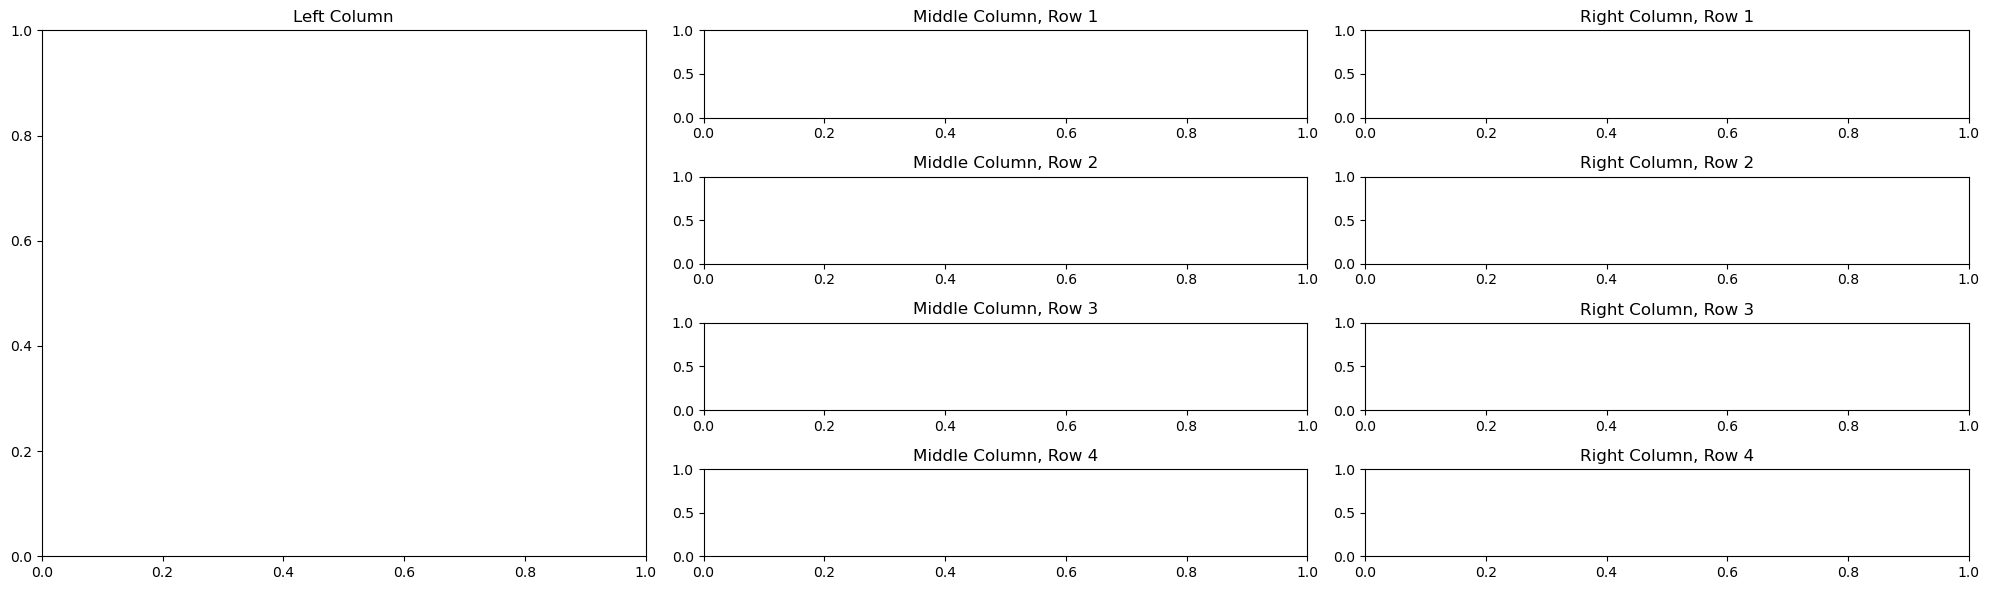

In [211]:
# # Temoplate ...
# fig = plt.figure(figsize=[20,6])

# # Define the grid layout
# # 1st column: 1 row, 1 column
# # 2nd column: 4 rows, 2 columns
# # We'll use GridSpec to manage the layout
# from matplotlib.gridspec import GridSpec

# # Create a GridSpec with 4 rows and 3 columns
# gs = GridSpec(4, 3, figure=fig)

# # Add the first subplot (full height of the first column)
# ax1 = fig.add_subplot(gs[:, 0])
# ax1.set_title('Left Column')

# # Add subplots for the second column (4 rows x 2 columns)
# ax2 = fig.add_subplot(gs[0, 1:2])
# ax3 = fig.add_subplot(gs[1, 1:2])
# ax4 = fig.add_subplot(gs[2, 1:2])
# ax5 = fig.add_subplot(gs[3, 1:2])

# # Add subplots for the third column (4 rows x 2 columns)
# ax6 = fig.add_subplot(gs[0, 2:])
# ax7 = fig.add_subplot(gs[1, 2:])
# ax8 = fig.add_subplot(gs[2, 2:])
# ax9 = fig.add_subplot(gs[3, 2:])

# # Titles for each subplot in the second and third columns
# ax2.set_title('Middle Column, Row 1')
# ax3.set_title('Middle Column, Row 2')
# ax4.set_title('Middle Column, Row 3')
# ax5.set_title('Middle Column, Row 4')

# ax6.set_title('Right Column, Row 1')
# ax7.set_title('Right Column, Row 2')
# ax8.set_title('Right Column, Row 3')
# ax9.set_title('Right Column, Row 4')

# fig.tight_layout()
# plt.show()

# AIA 171 &Aring;

In [12]:
channel = 171

# Check if the datetime is a string
if isinstance(start, str) and isinstance(end, str):
    dt_dict = myfuncs.split_datetime(start=start, end=end)

# Check if the datetime is a pandas.Timestamp
elif isinstance(start, pd.Timestamp) and isinstance(end, pd.Timestamp):
    dt_dict = myfuncs.split_datetime(start=str(start).replace(' ','T'), end=str(end).replace(' ','T'))

data_path = f'{data_dir}/AIA/{channel}A/{data_type}/lv15'
data = sorted(glob.glob(f'{data_path}/aia*{channel}A_*.fits'))

start_pattern = f"aia*{channel}A_{dt_dict['start_year']}_{dt_dict['start_month']}_{dt_dict['start_day']}T{dt_dict['start_hour']}_{dt_dict['start_minute']}*"
end_pattern   = f"aia*{channel}A_{dt_dict['end_year']}_{dt_dict['end_month']}_{dt_dict['end_day']}T{dt_dict['end_hour']}_{dt_dict['end_minute']}*"

first_file_to_find = sorted(glob.glob(f'{data_path}/{start_pattern}*.fits'))
last_file_to_find  = sorted(glob.glob(f'{data_path}/{end_pattern}*.fits'))

idx1 = data.index(first_file_to_find[0])
idx2 = data.index(last_file_to_find[0])

chosen_files = data[idx1:idx2]

map_objects = []
with tqdm(total=len(chosen_files), desc=f'Loading AIA {channel}A maps ...') as pbar:
    for i, file in enumerate(chosen_files):
        # load the file as a sunpy map
        m = sunpy.map.Map(file)
        map_objects.append(m)
        pbar.update(1)

Loading AIA 171A maps ...: 100%|████████████████████████████████████| 582/582 [01:35<00:00,  6.06it/s]


In [13]:
len(map_objects), map_objects[0].meta['t_obs'], map_objects[-1].meta['t_obs']

(582, '2024-05-14T17:00:10.34Z', '2024-05-14T18:58:58.35Z')

In [14]:
dict_maps['171A'] = map_objects

In [15]:
# idx = 177
# m = map_objects[idx]
# norm = ImageNormalize(vmin=0, vmax=7e3, stretch=AsinhStretch())

# # crop the region of interest
# top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
# bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
# m_submap = m.submap(bottom_left, top_right=top_right)

# # define a line over the vortex
# slit = SkyCoord(
#     Tx=[-877, -885]*u.arcsec,
#     Ty=[385, 370]*u.arcsec,
#     frame=m_submap.coordinate_frame
# )

# fig = plt.figure(figsize=[5,7])
# ax = fig.add_subplot(projection=m_submap)
# m_submap.plot(axes=ax, norm=norm)
# ax.plot_coord(slit, color='white', ls=':', lw=3)

# # Convert the slit coordinates to pixel coordinates for annotation
# start_pix, end_pix = m_submap.world_to_pixel(slit)
# x1pix, y1pix = start_pix.value
# # Annotate at the tip of the slit using pixel coordinates
# ax.annotate('1', xy=(x1pix, y1pix), xytext=(0,180),
#             textcoords='offset points', color='w', fontsize=15)
# ax.grid(False)
# fig.tight_layout()
# plt.show()

In [16]:
# # track how intensity evolves along the slit over the sequence of solar images
# for m in map_objects:
#     m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=7e3, stretch=AsinhStretch())

# intensity_stack = []
# with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
#     for m in map_objects:
#         with SphericalScreen(m.observer_coordinate):
#             _slit_pixelated = sunpy.map.pixelate_coord_path(m, slit)
#         _slit_distance = _slit_pixelated.separation(_slit_pixelated[0])
#         intensity = sunpy.map.sample_at_coords(m, _slit_pixelated)
#         f_interp = interp1d(_slit_distance.to_value('arcsec'), intensity.value, fill_value='extrapolate', kind='linear')
#         intensity_interp = f_interp(slit_distance.to_value('arcsec'))
#         intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
#         pbar.update(1)

# # get the time array and the distance along slit in arcsec
# time_array = [m.date.datetime for m in map_objects]
# distance = slit_distance.to(u.arcsec)

In [17]:
# fig, ax = plt.subplots(figsize=[15,5])
# ax.pcolormesh(time_array, distance.value, np.array(intensity_stack).T,
#               norm=ImageNormalize(stretch=AsinhStretch()),
#               cmap=sdoaia171)
# ax.text(0.985, 0.95, 'Slit 1', transform=ax.transAxes,
#         fontsize=15, color='white', verticalalignment='top', horizontalalignment='right')
# ax.set_ylabel('Distance along slit (arcsec)')
# ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
# fig.tight_layout()
# plt.show()

# AIA 193 &Aring;

In [18]:
channel = 193

# Check if the datetime is a string
if isinstance(start, str) and isinstance(end, str):
    dt_dict = myfuncs.split_datetime(start=start, end=end)

# Check if the datetime is a pandas.Timestamp
elif isinstance(start, pd.Timestamp) and isinstance(end, pd.Timestamp):
    dt_dict = myfuncs.split_datetime(start=str(start).replace(' ','T'), end=str(end).replace(' ','T'))

data_path = f'{data_dir}/AIA/{channel}A/{data_type}/lv15'
data = sorted(glob.glob(f'{data_path}/aia*{channel}A_*.fits'))

start_pattern = f"aia*{channel}A_{dt_dict['start_year']}_{dt_dict['start_month']}_{dt_dict['start_day']}T{dt_dict['start_hour']}_{dt_dict['start_minute']}*"
end_pattern   = f"aia*{channel}A_{dt_dict['end_year']}_{dt_dict['end_month']}_{dt_dict['end_day']}T{dt_dict['end_hour']}_{dt_dict['end_minute']}*"

first_file_to_find = sorted(glob.glob(f'{data_path}/{start_pattern}*.fits'))
last_file_to_find  = sorted(glob.glob(f'{data_path}/{end_pattern}*.fits'))

idx1 = data.index(first_file_to_find[0])
idx2 = data.index(last_file_to_find[0])

chosen_files = data[idx1:idx2]

map_objects = []
with tqdm(total=len(chosen_files), desc=f'Loading AIA {channel}A maps ...') as pbar:
    for i, file in enumerate(chosen_files):
        # load the file as a sunpy map
        m = sunpy.map.Map(file)
        map_objects.append(m)
        pbar.update(1)

Loading AIA 193A maps ...: 100%|████████████████████████████████████| 254/254 [00:54<00:00,  4.67it/s]


In [19]:
len(map_objects), map_objects[0].meta['t_obs'], map_objects[-1].meta['t_obs']

(254, '2024-05-14T17:00:07.23Z', '2024-05-14T18:58:17.84Z')

In [20]:
dict_maps['193A'] = map_objects

In [21]:
# idx = 71
# m = map_objects[idx]
# norm = ImageNormalize(vmin=0, vmax=8e3, stretch=AsinhStretch())

# # crop the region of interest
# top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
# bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
# m_submap = m.submap(bottom_left, top_right=top_right)

# # define a line over the vortex
# slit = SkyCoord(
#     Tx=[-877, -885]*u.arcsec,
#     Ty=[385, 370]*u.arcsec,
#     frame=m_submap.coordinate_frame
# )

# fig = plt.figure(figsize=[5,7])
# ax = fig.add_subplot(projection=m_submap)
# m_submap.plot(axes=ax, norm=norm)
# ax.plot_coord(slit, color='white', ls=':', lw=3)

# # Convert the slit coordinates to pixel coordinates for annotation
# start_pix, end_pix = m_submap.world_to_pixel(slit)
# x1pix, y1pix = start_pix.value
# # Annotate at the tip of the slit using pixel coordinates
# ax.annotate('1', xy=(x1pix, y1pix), xytext=(0,180),
#             textcoords='offset points', color='w', fontsize=15)
# ax.grid(False)
# fig.tight_layout()
# plt.show()

In [22]:
# # track how intensity evolves along the slit over the sequence of solar images
# for m in map_objects:
#     m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=8e3, stretch=AsinhStretch())

# intensity_stack = []
# with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
#     for m in map_objects:
#         with SphericalScreen(m.observer_coordinate):
#             _slit_pixelated = sunpy.map.pixelate_coord_path(m, slit)
#         _slit_distance = _slit_pixelated.separation(_slit_pixelated[0])
#         intensity = sunpy.map.sample_at_coords(m, _slit_pixelated)
#         f_interp = interp1d(_slit_distance.to_value('arcsec'), intensity.value, fill_value='extrapolate', kind='linear')
#         intensity_interp = f_interp(slit_distance.to_value('arcsec'))
#         intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
#         pbar.update(1)

# # get the time array and the distance along slit in arcsec
# time_array = [m.date.datetime for m in map_objects]
# distance = slit_distance.to(u.arcsec)

In [23]:
# fig, ax = plt.subplots(figsize=[15,5])
# ax.pcolormesh(time_array, distance.value, np.array(intensity_stack).T,
#               norm=ImageNormalize(stretch=AsinhStretch()),
#               cmap=sdoaia193)
# ax.text(0.985, 0.95, 'Slit 1', transform=ax.transAxes,
#         fontsize=15, color='white', verticalalignment='top', horizontalalignment='right')
# ax.set_ylabel('Distance along slit (arcsec)')
# ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
# fig.tight_layout()
# plt.show()

# AIA 211 &Aring;

In [24]:
channel = 211

# Check if the datetime is a string
if isinstance(start, str) and isinstance(end, str):
    dt_dict = myfuncs.split_datetime(start=start, end=end)

# Check if the datetime is a pandas.Timestamp
elif isinstance(start, pd.Timestamp) and isinstance(end, pd.Timestamp):
    dt_dict = myfuncs.split_datetime(start=str(start).replace(' ','T'), end=str(end).replace(' ','T'))

data_path = f'{data_dir}/AIA/{channel}A/{data_type}/lv15'
data = sorted(glob.glob(f'{data_path}/aia*{channel}A_*.fits'))

start_pattern = f"aia*{channel}A_{dt_dict['start_year']}_{dt_dict['start_month']}_{dt_dict['start_day']}T{dt_dict['start_hour']}_{dt_dict['start_minute']}*"
end_pattern   = f"aia*{channel}A_{dt_dict['end_year']}_{dt_dict['end_month']}_{dt_dict['end_day']}T{dt_dict['end_hour']}_{dt_dict['end_minute']}*"

first_file_to_find = sorted(glob.glob(f'{data_path}/{start_pattern}*.fits'))
last_file_to_find  = sorted(glob.glob(f'{data_path}/{end_pattern}*.fits'))

idx1 = data.index(first_file_to_find[0])
idx2 = data.index(last_file_to_find[0])

chosen_files = data[idx1:idx2]

map_objects = []
with tqdm(total=len(chosen_files), desc=f'Loading AIA {channel}A maps ...') as pbar:
    for i, file in enumerate(chosen_files):
        # load the file as a sunpy map
        m = sunpy.map.Map(file)
        map_objects.append(m)
        pbar.update(1)

Loading AIA 211A maps ...: 100%|████████████████████████████████████| 452/452 [01:45<00:00,  4.29it/s]


In [25]:
len(map_objects), map_objects[0].meta['t_obs'], map_objects[-1].meta['t_obs']

(452, '2024-05-14T17:00:13.21Z', '2024-05-14T18:58:59.08Z')

In [26]:
dict_maps['211A'] = map_objects

In [27]:
# idx = 126
# m = map_objects[idx]
# norm = ImageNormalize(vmin=0, vmax=5e3, stretch=AsinhStretch())

# # crop the region of interest
# top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
# bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
# m_submap = m.submap(bottom_left, top_right=top_right)

# define a line over the vortex
slit = SkyCoord(
    Tx=[-877, -885]*u.arcsec,
    Ty=[385, 370]*u.arcsec,
    frame=m_submap.coordinate_frame
)

# fig = plt.figure(figsize=[5,7])
# ax = fig.add_subplot(projection=m_submap)
# m_submap.plot(axes=ax, norm=norm)
# ax.plot_coord(slit, color='white', ls=':', lw=3)

# # Convert the slit coordinates to pixel coordinates for annotation
# start_pix, end_pix = m_submap.world_to_pixel(slit)
# x1pix, y1pix = start_pix.value
# # Annotate at the tip of the slit using pixel coordinates
# ax.annotate('1', xy=(x1pix, y1pix), xytext=(0,180),
#             textcoords='offset points', color='w', fontsize=15)
# ax.grid(False)
# fig.tight_layout()
# plt.show()

In [28]:
# # track how intensity evolves along the slit over the sequence of solar images
# for m in map_objects:
#     m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5e3, stretch=AsinhStretch())

# intensity_stack = []
# with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
#     for m in map_objects:
#         with SphericalScreen(m.observer_coordinate):
#             _slit_pixelated = sunpy.map.pixelate_coord_path(m, slit)
#         _slit_distance = _slit_pixelated.separation(_slit_pixelated[0])
#         intensity = sunpy.map.sample_at_coords(m, _slit_pixelated)
#         f_interp = interp1d(_slit_distance.to_value('arcsec'), intensity.value, fill_value='extrapolate', kind='linear')
#         intensity_interp = f_interp(slit_distance.to_value('arcsec'))
#         intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
#         pbar.update(1)

# # get the time array and the distance along slit in arcsec
# time_array = [m.date.datetime for m in map_objects]
# distance = slit_distance.to(u.arcsec)

In [30]:
# fig, ax = plt.subplots(figsize=[15,5])
# ax.pcolormesh(time_array, distance.value, np.array(intensity_stack).T,
#               norm=ImageNormalize(stretch=AsinhStretch()),
#               cmap=sdoaia211)
# ax.text(0.985, 0.95, 'Slit 1', transform=ax.transAxes,
#         fontsize=15, color='white', verticalalignment='top', horizontalalignment='right')
# ax.set_ylabel('Distance along slit (arcsec)')
# ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
# fig.tight_layout()
# plt.show()

In [32]:
print(len(dict_maps['171A']))
print(len(dict_maps['193A']))
print(len(dict_maps['211A']))
print(len(dict_maps['304A']))

582
254
452
592


# Make composite RGB maps

In [33]:
# from skimage.transform import resize

In [34]:
# dict_maps['171A'][177].data.shape, dict_maps['193A'][71].data.shape, dict_maps['211A'][126].data.shape, dict_maps['304A'][177].data.shape

In [35]:
# def enhance_contrast(image, vmin, vmax):
#     """
#     Enhance contrast by clipping and normalization.
#     """
#     image_clipped = np.clip(image, vmin, vmax)
#     image_normalized = (image_clipped - vmin) / (vmax - vmin)
#     return image_normalized


# def calculate_percentiles(image, lower_percentile=3, upper_percentile=97):
#     """
#     Calculate vmin and vmax based on the 1st and 99th percentiles.
#     """
#     vmin = np.percentile(image, lower_percentile)
#     vmax = np.percentile(image, upper_percentile)
#     return vmin, vmax

In [36]:
# m1 = dict_maps['171A'][177]
# m2 = dict_maps['193A'][71]
# m3 = dict_maps['211A'][126]

# enhanced = False

# # Determine the target shape (smallest shape among the three images)
# target_shape = (min(m1.data.shape[0], m2.data.shape[0], m3.data.shape[0]),
#                 min(m1.data.shape[1], m2.data.shape[1], m3.data.shape[1]))

# # Resize each image to the target shape
# m1_resized = resize(m1.data, target_shape, preserve_range=True)
# m2_resized = resize(m2.data, target_shape, preserve_range=True)
# m3_resized = resize(m3.data, target_shape, preserve_range=True)

# # Stack the resized images
# rgb_image = np.stack([m1_resized, m2_resized, m3_resized], axis=-1)

In [37]:
# # Normalize the data
# m1_resized = (m1_resized - np.min(m1_resized)) / (np.max(m1_resized) - np.min(m1_resized))
# m2_resized = (m2_resized - np.min(m2_resized)) / (np.max(m2_resized) - np.min(m2_resized))
# m3_resized = (m3_resized - np.min(m3_resized)) / (np.max(m3_resized) - np.min(m3_resized))

# # Stack the resized images into an RGB composite (each map corresponds to one color channel)
# rgb_image = np.stack([m1_resized, m2_resized, m3_resized], axis=-1)

In [38]:
# if enhanced:
#     # Enhance contrast for each channel
#     rgb_image_enhanced = np.zeros_like(rgb_image)
#     for i in range(3):  # Process each channel independently
#         vmin, vmax = calculate_percentiles(rgb_image[..., i])
#         rgb_image_enhanced[..., i] = enhance_contrast(rgb_image[..., i], vmin, vmax)
#     # Convert the 3D array to a 2D array by averaging the channels
#     array_2d = np.mean(rgb_image_enhanced, axis=2)
# else:
#     # Convert the 3D array to a 2D array by averaging the channels
#     array_2d = np.mean(rgb_image, axis=2)

# # Create a SunPy map with the resulting array
# m_rgb = sunpy.map.Map(array_2d, m1.meta)

In [39]:
# # rgb = sunpy.map.Map(array_2d, m1.meta)
# rgb_image.shape

In [40]:
# # Display the composite image
# fig, ax = plt.subplots()
# ax.imshow(rgb_image, aspect='auto', origin='lower')
# plt.show()

In [43]:
# top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m_rgb.coordinate_frame)
# bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m_rgb.coordinate_frame)
# m_rgb_submap = m_rgb.submap(bottom_left, top_right=top_right)

# fig = plt.figure(figsize=[7,7])
# ax = fig.add_subplot(projection=m_rgb_submap)
# m_rgb_submap.plot(axes=ax, norm=LogNorm())
# ax.grid(False)
# fig.tight_layout()
# plt.show()

In [44]:
# m = map_objects[177]
# top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
# bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
# m_submap = m.submap(bottom_left, top_right=top_right)

In [45]:
# %matplotlib widget
# %matplotlib notebook
# %matplotlib inline

# Plot multiple slits

In [54]:
# import scipy.ndimage
# import cv2
# import sunpy.data.sample
# import sunpy.map


# def draw_rectangle(center=(0, 0), width=1, height=1, angle=0):
#     """
#     Function to draw a rotated rectangle and return its corners.
#     Inputs:
#     =======
#     center : Center of the rectangle
#     width, height : Width and height of the rectangle
#     angle : Rotation angle in degrees
#     """
#     # Generate rectangle corners (without rotation)
#     half_width, half_height = width / 2, height / 2
#     rectangle = np.array([
#         [-half_width, -half_height],
#         [half_width, -half_height],
#         [half_width, half_height],
#         [-half_width, half_height]
#     ])
#     # Rotation matrix
#     theta = np.radians(angle)
#     rotation_matrix = np.array([
#         [np.cos(theta), -np.sin(theta)],
#         [np.sin(theta), np.cos(theta)]
#     ])
#     # Rotate the rectangle
#     rotated_rectangle = rectangle @ rotation_matrix.T
#     # Translate to the center point
#     rotated_rectangle += np.array(center)
#     return rotated_rectangle


# def crop_rotated_rectangle(image, center, width, height, angle):
#     """
#     Function to extract the pixels inside the rotated rectangle using OpenCV.
#     """
#     # Get the rectangle's corner points
#     rotated_rectangle = draw_rectangle(center, width, height, angle)
#     # Compute the affine transform matrix to warp the image
#     # We need three points from the rotated rectangle and their corresponding locations in a new axis-aligned rectangle
#     src_pts = np.float32(rotated_rectangle[:3])  # Three points from the rotated rectangle
#     dst_pts = np.float32([[0, 0], [width, 0], [width, height]])  # Mapped to a straight rectangle
#     # Get the affine transformation matrix
#     M = cv2.getAffineTransform(src_pts, dst_pts)
#     # Apply the affine transformation to warp the image
#     cropped_image = cv2.warpAffine(image, M, (int(width), int(height)))
#     return cropped_image

In [55]:
# def crop_rotated_rectangle(image, center, width, height, angle):
#     """
#     Function to extract the pixels inside the rotated rectangle using OpenCV.
#     """
#     # Get the rectangle's corner points
#     rotated_rectangle = draw_rectangle(center, width, height, angle)
    
#     # Create a mesh grid for the target coordinates (output image)
#     xx, yy = np.meshgrid(np.arange(width), np.arange(height))
    
#     # Compute the rotation matrix
#     theta = np.radians(angle)
#     inverse_rotation_matrix = np.array([
#         [np.cos(theta), -np.sin(theta)],
#         [np.sin(theta), np.cos(theta)]
#     ])
#     # Translate the mesh grid to the center and apply rotation
#     xy_grid = np.vstack([xx.ravel() - width / 2, yy.ravel() - height / 2])  # Center the grid
#     rotated_grid = inverse_rotation_matrix @ xy_grid  # Apply the rotation
    
#     # Step 5: Translate the grid back to the original image's coordinate system
#     rotated_grid[0, :] += center[0]  # X-coordinates
#     rotated_grid[1, :] += center[1]  # Y-coordinates

#     # Interpolate the pixel values using scipy's map_coordinates
#     rotated_grid = rotated_grid.reshape(2, height, width)  # Reshape back into 2D grid
#     cropped_image = scipy.ndimage.map_coordinates(image, [rotated_grid[1], rotated_grid[0]], order=1, mode='reflect')
    
#     return cropped_image

In [56]:
# # usage
# center = (850, 300)
# width  = 100
# height = 300
# angle  = 45

# rotated_rectangle = draw_rectangle(center=center, width=width, height=height, angle=angle)
# aia_map = sunpy.map.Map(sunpy.data.sample.AIA_304_IMAGE)
# image = aia_map.data

# # Crop the rotated rectangle region
# cropped_image = crop_rotated_rectangle(image, center=center, width=width, height=height, angle=angle)

# fig = plt.figure(figsize=[10,5])
# # Plot the original image with the rotated rectangle
# ax = fig.add_subplot(121)
# ax.imshow(image, origin='lower', vmin=0, vmax=3e2)
# ax.plot(*zip(*np.vstack([rotated_rectangle, rotated_rectangle[0]])), color='w')
# # Plot the cropped result
# ax = fig.add_subplot(122)
# ax.imshow(cropped_image, origin='lower', vmin=0, vmax=3e2)
# fig.tight_layout()
# plt.show()

In [57]:
# fig = plt.figure(figsize=[5,7])
# ax = fig.add_subplot(projection=m_submap)
# m_submap.plot(axes=ax, norm=norm)
# ax.grid(False)
# fig.tight_layout()
# plt.show()

In [58]:
# # usage
# center = (65, 128)
# width  = 12
# height = 28
# angle  = 52

# rotated_rectangle = draw_rectangle(center=center, width=width, height=height, angle=angle)
# image = m_submap.data.astype(np.float64)

# # Crop the rotated rectangle region
# cropped_image = crop_rotated_rectangle(image, center=center, width=width, height=height, angle=angle)

# fig = plt.figure(figsize=[7,5])
# # Plot the original image with the rotated rectangle
# ax = fig.add_subplot(121)
# ax.imshow(image, origin='lower', vmin=0, vmax=4e2)
# ax.plot(*zip(*np.vstack([rotated_rectangle, rotated_rectangle[0]])), color='w')
# # Plot the cropped result
# ax = fig.add_subplot(122)
# ax.imshow(cropped_image, origin='lower', vmin=0, vmax=4e2)
# fig.tight_layout()
# plt.show()

In [59]:
# # Sum the pixel values over the columns into a 1D array (one column)
# summed_pixels = np.sum(cropped_image, axis=1)
# summed_pixels

In [60]:
# plt.plot(summed_pixels)
# plt.show()

In [61]:
# intensity_stack = []
# with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
#     for m in map_objects:
#         image = m.data.astype(np.float64)
#         cropped_image = crop_rotated_rectangle(image, center=center, width=width, height=height, angle=angle)
#         summed_pixels = np.sum(cropped_image, axis=1)
#         intensity_stack.append(summed_pixels)
#         pbar.update(1)

In [62]:
# concatenated_array = np.vstack(intensity_stack)
# print(concatenated_array.shape)  # Output will be (10, 28), assuming you have 10 arrays

In [63]:
# fig, ax = plt.subplots(figsize=[10,5])
# ax.pcolormesh(time_array,
#               np.arange(concatenated_array.shape[1]),
#               concatenated_array.T,
#               # norm=ImageNormalize(stretch=AsinhStretch()),
#               # norm=LogNorm(),
#               # cmap=sdoaia304
#              )
# ax.set_ylabel('Distance bins')
# # ax.set_ylabel('Distance along slit (arcsec)')
# ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
# fig.tight_layout()
# plt.show()

## Do a semi-cericular loop over the vortex and extract the intensities and stack them in a 2D array

In [64]:
# fig = plt.figure(figsize=[7,10])
# ax = fig.add_subplot(projection=aia_map)
# aia_map.plot(axes=ax, norm=norm)
# ax.minorticks_on()
# aia_map.draw_grid(grid_spacing=10*u.deg)
# fig.tight_layout()
# plt.show()

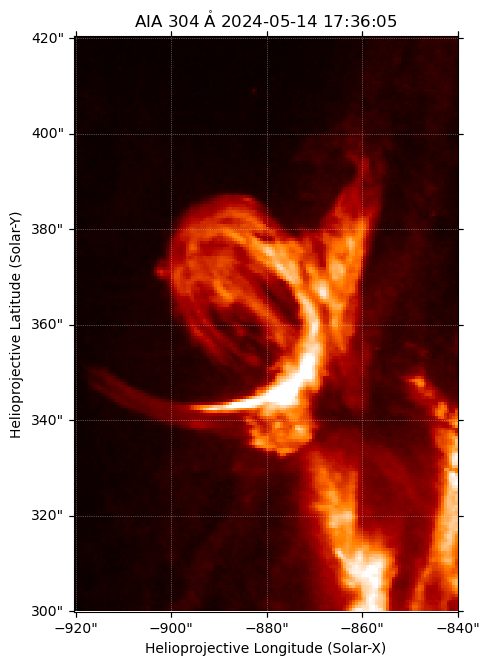

In [7]:
fig = plt.figure(figsize=[5,7])
ax = fig.add_subplot(projection=m_submap)
m_submap.plot(axes=ax, norm=norm)
fig.tight_layout()
plt.show()

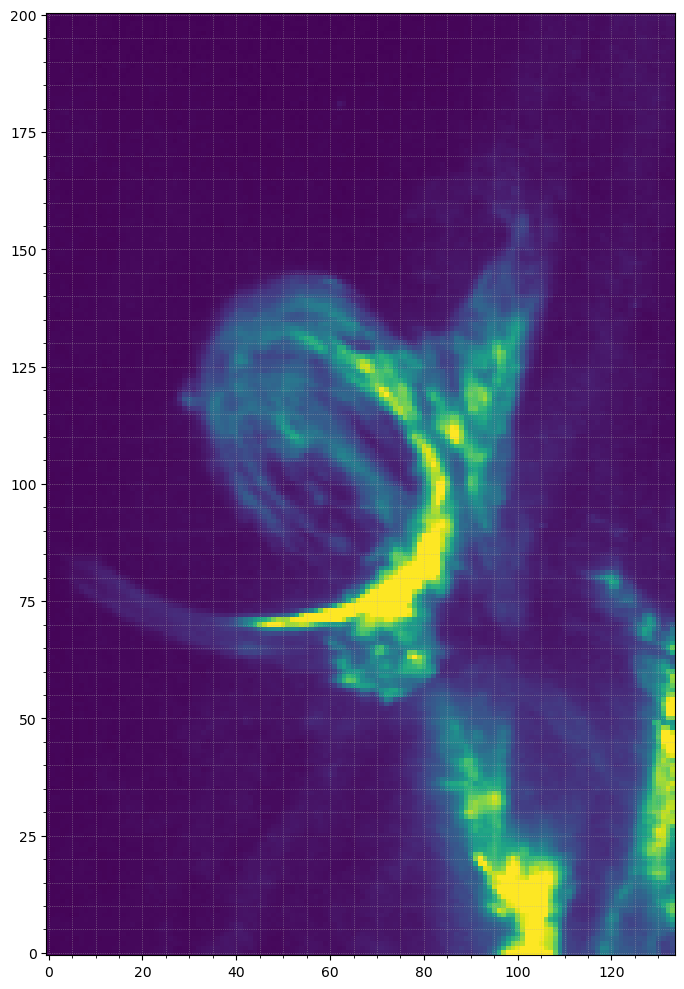

In [8]:
subimage = m_submap.data.astype(np.float64)

fig = plt.figure(figsize=[7,10])
ax = fig.add_subplot(111)
ax.imshow(subimage, origin='lower', vmin=0, vmax=4e2)
ax.minorticks_on()
ax.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)
fig.tight_layout()
plt.show()

In [14]:
# def draw_quadratic_bezier(x1=0, y1=0, x2=0, y2=0, control=[0,0]):
#     """
#     Draw a Quadratic Bezier curve using the given control points.
#     The curve will be drawn from the point (x1, y1) to the point
#     (x2, y2) using the control points (control[0], control[1]).
#     """
#     # Convert points to numpy arrays
#     P0 = np.array([x1, y1])  # Start point
#     P1 = np.array(control)    # Control point
#     P2 = np.array([x2, y2])   # End point

#     # Create time steps t from 0 to 1
#     t = np.linspace(0, 1, 50)  # 100 points for smoothness

#     # Quadratic Bézier formula: B(t) = (1-t)^2 * P0 + 2*(1-t)*t * P1 + t^2 * P2
#     bezier_curve = (1 - t)[:, None] ** 2 * P0 + \
#                    2 * (1 - t)[:, None] * t[:, None] * P1 + \
#                    t[:, None] ** 2 * P2

#     return bezier_curve


# def extract_quadratic_bezier_values(array, x1, y1, x2, y2, control):
#     """
#     Extract the values of a Bezier curve at the given control points.
#     The curve will be drawn from the point (x1, y1) to the point
#     (x2, y2) using the control points (control[0], control[1]).
#     """
#     bezier_curve = draw_quadratic_bezier(x1, y1, x2, y2, control)
    
#     # Get the x and y coordinates
#     x_coords = np.round(bezier_curve[:, 0]).astype(int)
#     y_coords = np.round(bezier_curve[:, 1]).astype(int)

#     # Clip the coordinates to stay within array bounds
#     x_coords = np.clip(x_coords, 0, array.shape[1] - 1)
#     y_coords = np.clip(y_coords, 0, array.shape[0] - 1)

#     # Extract values along the Bézier curve
#     bezier_values = array[y_coords, x_coords]
    
#     return bezier_values, x_coords, y_coords





# # Example usage in your plot
# x1 = 80
# y1 = 110
# x2 = 50
# y2 = 90
# control = [40, 160]

# fig = plt.figure(figsize=[7,10])
# ax = fig.add_subplot(111)
# ax.imshow(subimage, origin='lower', vmin=0, vmax=4e2)
# _, x_coords, y_coords = extract_quadratic_bezier_values(subimage, x1, y1, x2, y2, control)
# ax.plot(x_coords, y_coords, 'ko--', linewidth=1, markersize=3)
# ax.minorticks_on()
# ax.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)
# fig.tight_layout()
# plt.show()

In [313]:
# Example usage
m = map_objects[177] # loop_1: 177, loop_2: 200
norm = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch())
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)
subimage = m_submap.data.astype(np.float64)

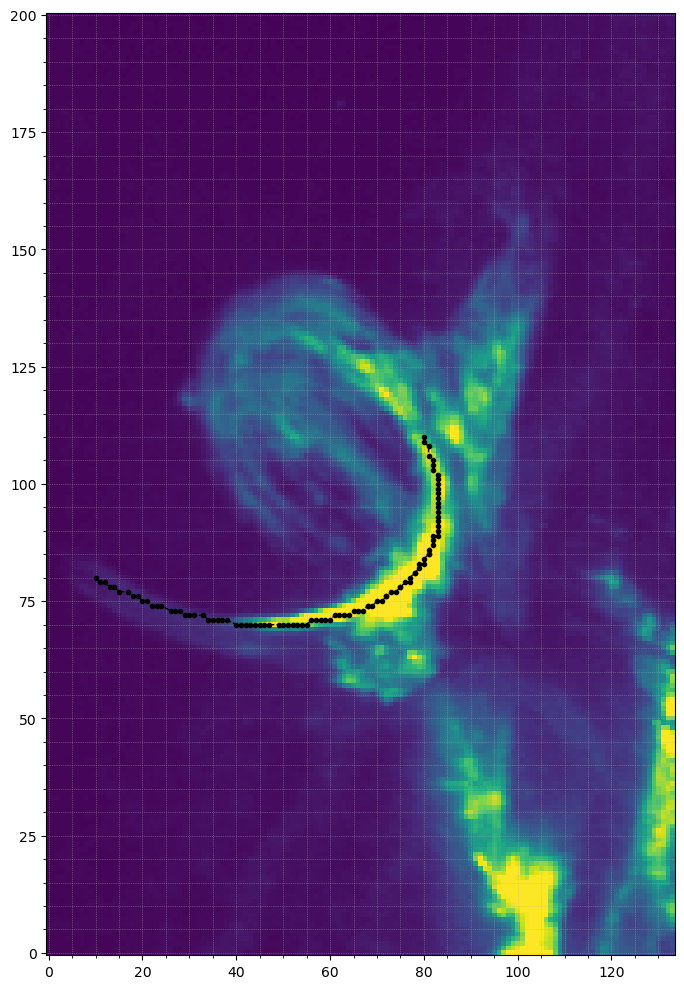

In [215]:
x1 = 10
y1 = 80
x2 = 80
y2 = 110
control1 = [45, 60]  # First control point
control2 = [97, 70]  # Second control point

fig = plt.figure(figsize=[7,10])
ax = fig.add_subplot(111)
ax.imshow(subimage, origin='lower', vmin=0, vmax=4e2)

# intens, x_coords, y_coords = myfuncs.extract_bezier_values(subimage, x1, y1, x2, y2, [control1], n=2)
intens, x_coords, y_coords = myfuncs.extract_bezier_values(subimage, x1, y1, x2, y2, [control1, control2], n=3)
ax.plot(x_coords, y_coords, 'ko--', linewidth=1, markersize=3)

ax.minorticks_on()
ax.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)
fig.tight_layout()
plt.show()

In [12]:
# m = map_objects[200]
# top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
# bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
# m_submap = m.submap(bottom_left, top_right=top_right)
# subimage = m_submap.data.astype(np.float64)

# fig = plt.figure(figsize=[7,10])
# ax = fig.add_subplot(111)
# ax.imshow(subimage, origin='lower', vmin=0, vmax=4e2)
# fig.tight_layout()
# plt.show()

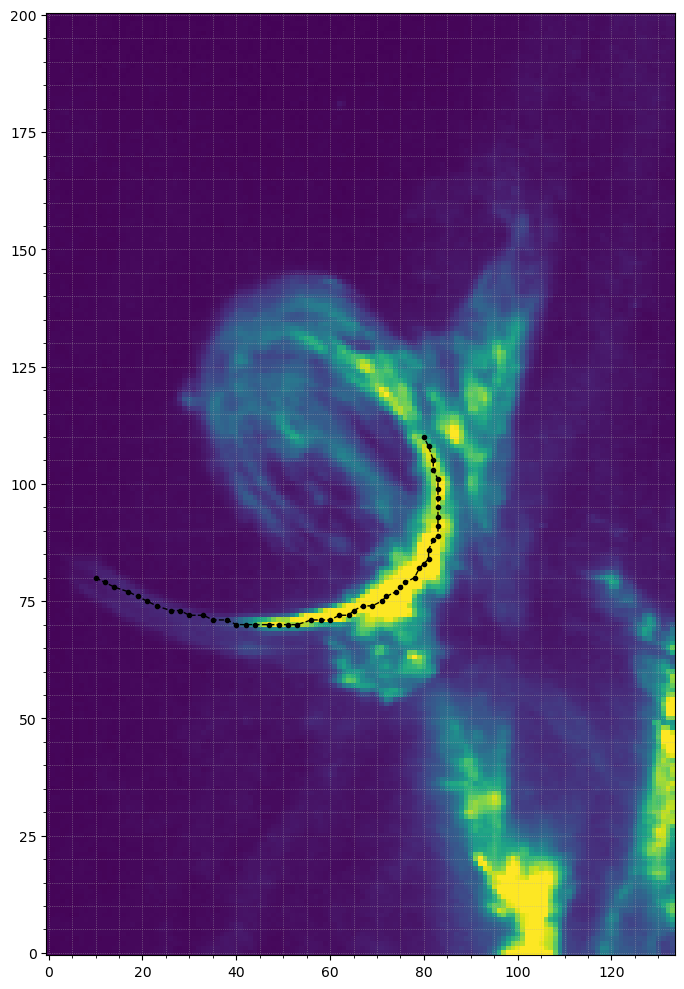

In [217]:
def draw_cubic_bezier(x1=0, y1=0, x2=0, y2=0, control1=[0,0], control2=[0,0]):
    """
    Draw a Cubic Bézier curve using two control points.
    The curve will be drawn from the point (x1, y1) to the point (x2, y2) 
    using the control points control1 and control2.
    """
    # Convert points to numpy arrays
    P0 = np.array([x1, y1])  # Start point
    P1 = np.array(control1)   # First control point
    P2 = np.array(control2)   # Second control point
    P3 = np.array([x2, y2])   # End point

    # Create time steps t from 0 to 1
    t = np.linspace(0, 1, 50)  # 100 points for smoothness

    # Cubic Bézier formula: B(t) = (1 - t)^3 * P0 + 3*(1 - t)^2 * t * P1 + 3*(1 - t) * t^2 * P2 + t^3 * P3
    bezier_curve = (1 - t)[:, None] ** 3 * P0 + \
                   3 * (1 - t)[:, None] ** 2 * t[:, None] * P1 + \
                   3 * (1 - t)[:, None] * t[:, None] ** 2 * P2 + \
                   t[:, None] ** 3 * P3

    return bezier_curve

def extract_cubic_bezier_values(array, x1, y1, x2, y2, control1, control2):
    """
    Extract the values of a Cubic Bézier curve using two control points.
    The curve will be drawn from the point (x1, y1) to the point (x2, y2)
    using the control points control1 and control2.
    """
    bezier_curve = draw_cubic_bezier(x1, y1, x2, y2, control1, control2)
    
    # Get the x and y coordinates
    x_coords = np.round(bezier_curve[:, 0]).astype(int)
    y_coords = np.round(bezier_curve[:, 1]).astype(int)

    # Clip the coordinates to stay within array bounds
    x_coords = np.clip(x_coords, 0, array.shape[1] - 1)
    y_coords = np.clip(y_coords, 0, array.shape[0] - 1)

    # Extract values along the Bézier curve
    bezier_values = array[y_coords, x_coords]
    
    return bezier_values, x_coords, y_coords




# Example usage in your plot
m = map_objects[177] # loop_1: 177, loop_2: 200
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)
subimage = m_submap.data.astype(np.float64)

x1 = 10
y1 = 80
x2 = 80
y2 = 110
control1 = [45, 60]  # First control point
control2 = [97, 70]  # Second control point

fig = plt.figure(figsize=[7,10])
ax = fig.add_subplot(111)
ax.imshow(subimage, origin='lower', vmin=0, vmax=4e2)

intens, x_coords, y_coords = extract_cubic_bezier_values(subimage, x1, y1, x2, y2, control1, control2)
ax.plot(x_coords, y_coords, 'ko--', linewidth=1, markersize=3)

ax.minorticks_on()
ax.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)
fig.tight_layout()
plt.show()

In [745]:
diameter_pix = np.sqrt(40**2 + 45**2)
diameter_rsun = (diameter_pix/m_submap.rsun_obs.value)*u.R_sun
print(f'Diamaeter of vortrex: {diameter_pix:.2f} pix')
print(f'Diamaeter of vortrex: {diameter_rsun:.2f} Rsun')
print(f'Diamaeter of vortrex: {diameter_rsun.to(u.Mm):.2f}')

Diamaeter of vortrex: 60.21 pix
Diamaeter of vortrex: 0.06 solRad Rsun
Diamaeter of vortrex: 44.11 Mm


In [394]:
segments = {
    'x1': [10, 80, 92, 107],
    'y1': [80, 110, 115, 155],
    'x2': [80, 50, 107, 80],
    'y2': [110, 90, 155, 135], 
    'control1': [ [45,60], [55,160], [105,145], [115,195] ],
    'control2': [ [97,70], [15,125], [95,115], [45,170] ]
}

vortex_segments_coords = {
    'seg1_x': [],
    'seg1_y': [],
    
    'seg2_x': [],
    'seg2_y': [],
    
    'seg3_x': [],
    'seg3_y': [],
    
    'seg4_x': [],
    'seg4_y': []
}

jplots = {
    'time': [],
    
    'dist_s1': [],
    'dist_s2': [],
    'dist_s3': [],
    'dist_s4': [],

    'data_s1': [],
    'data_s2': [],
    'data_s3': [],
    'data_s4': []
}

fit_line_coords = {
    'x1': [85, 121, 167, 182],
    'x2': [115, 144, 181, 199],
    'y1': [50, 0, 0, 0],
    'y2': [75.6, 76.8, 33, 65.4],
    'control1': [ [105,60], [135,30], [180,20], [195,25]],
    'control2': [ [np.nan,np.nan], [145,40], [np.nan,np.nan], [np.nan,np.nan] ]
}

In [448]:
round(distance[-1], 2)

65.4

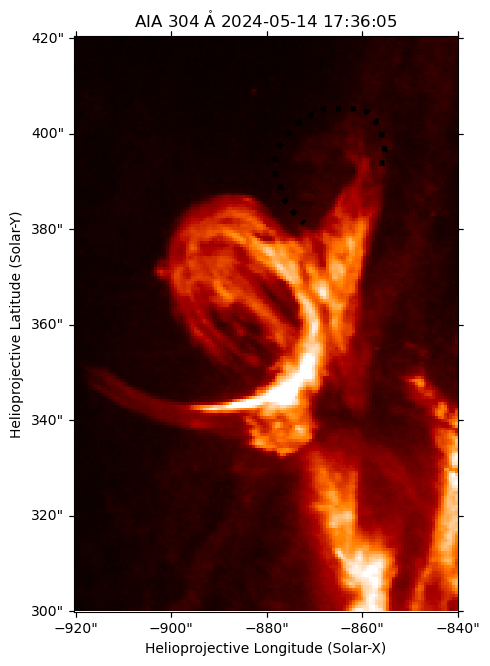

In [425]:
i = 3

# extract the curved slit coords in pixels
_, x_coords, y_coords = myfuncs.extract_bezier_values(subimage,
                                                   segments['x1'][i],
                                                   segments['y1'][i],
                                                   segments['x2'][i],
                                                   segments['y2'][i],
                                                   [
                                                       segments['control1'][i],
                                                       segments['control2'][i]
                                                   ],
                                                   n=3)
vortex_segments_coords[f'seg{i+1}_x'] = x_coords
vortex_segments_coords[f'seg{i+1}_y'] = y_coords

m = map_objects[177]
norm = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch())
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)

# convert pixel coordinates to world coordinates
slit = m_submap.pixel_to_world(x_coords * u.pixel, y_coords * u.pixel)

fig = plt.figure(figsize=[5,7])
ax = fig.add_subplot(projection=m_submap)
m_submap.plot(axes=ax, norm=norm)
ax.plot_coord(slit, color='k', ls=':', lw=4)
ax.grid(False)
fig.tight_layout()
plt.show()

In [426]:
# track how intensity evolves along the slit over the sequence of solar images
time_array = []
intensity_stack = []

with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
    for m in map_objects:
        # extract the map time
        time_array.append(m.date.datetime)
        # crop the region of interest
        top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
        bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
        m_submap = m.submap(bottom_left, top_right=top_right)
        # convert the submap to an array
        subimage = m_submap.data.astype(np.float64)
        # extract the curved slit coords in pixels
        _, x_coords, y_coords = myfuncs.extract_bezier_values(subimage,
                                                           segments['x1'][i],
                                                           segments['y1'][i],
                                                           segments['x2'][i],
                                                           segments['y2'][i],
                                                           [
                                                               segments['control1'][i],
                                                               segments['control2'][i]
                                                           ],
                                                           n=3)
        # convert pixel coordinates to world coordinates
        slit = m_submap.pixel_to_world(x_coords * u.pixel, y_coords * u.pixel)
        # extract and stack intensity along the slit
        with SphericalScreen(m.observer_coordinate):
            slit_pixelated = sunpy.map.pixelate_coord_path(m_submap, slit)
        # slit_distance = slit_pixelated.separation(slit_pixelated[0])
        angular_distances = slit_pixelated[:-1].separation(slit_pixelated[1:])
        # Compute the cumulative sum of the angular distances
        cumulative_distances = np.cumsum(angular_distances)
        # Add 0 at the start to represent the distance at the first point
        cumulative_distances_with_start = np.insert(cumulative_distances, 0, 0*u.arcsec)
        # sample the intensity at those coords
        intensity = sunpy.map.sample_at_coords(m_submap, slit_pixelated)
        # interpolate intensity along angular distance
        f_interp = interp1d(cumulative_distances_with_start, intensity.value, fill_value='extrapolate', kind='linear')
        intensity_interp = f_interp(cumulative_distances_with_start)
        # add the intensity array to the list
        intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
        pbar.update(1)

# get the distance along slit in arcsec
distance = cumulative_distances_with_start.to(u.arcsec).value
concatenated_array = np.vstack(intensity_stack).value.T

Stack intensities ...: 100%|████████████████████████████████████████| 592/592 [01:36<00:00,  6.13it/s]


In [427]:
# fig, ax = plt.subplots(figsize=[10,5])
# ax.pcolormesh(time_array,
#               distance,
#               concatenated_array,
#               norm=ImageNormalize(vmin=0, vmax=400, stretch=AsinhStretch()),
#               cmap=sdoaia304
#              )
# ax.set_ylabel('Distance along slit (arcsec)')
# ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
# fig.tight_layout()
# plt.show()

In [495]:
from matplotlib.ticker import AutoMinorLocator

fit_line_coords

{'x1': [182, 167, 121, 85],
 'x2': [199, 181, 144, 115],
 'y1': [0, 0, 0, 50],
 'y2': [65.4, 33, 76.8, 75.6],
 'control1': [[195, 25], [180, 20], [135, 30], [105, 60]],
 'control2': [[nan, nan], [nan, nan], [145, 40], [nan, nan]]}

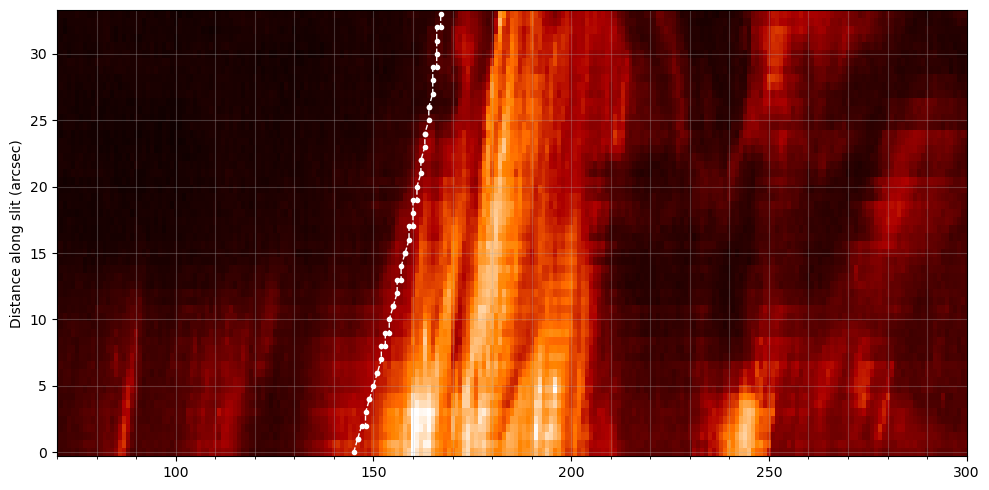

In [513]:
i = 1
# x1 = fit_line_coords['x1'][i]
# x2 = fit_line_coords['x2'][i]
# y1 = fit_line_coords['y1'][i]
# y2 = fit_line_coords['y2'][i]
# control1 = fit_line_coords['control1'][i]
# control2 = fit_line_coords['control2'][i]

x1 = 145
x2 = 167
y1 = fit_line_coords['y1'][i]
y2 = fit_line_coords['y2'][i]
control1 = [161, 15]
control2 = fit_line_coords['control2'][i]

fig, ax = plt.subplots(figsize=[10,5])
# ax.pcolormesh(np.arange(concatenated_array.shape[1]),
#               distance,
#               concatenated_array,
#               norm=ImageNormalize(vmin=0, vmax=400, stretch=AsinhStretch()),
#               cmap=sdoaia304
#              )
ax.pcolormesh(np.arange(jplots[f'data_s{i+1}'][0].shape[1]),
              jplots[f'dist_s{i+1}'],
              jplots[f'data_s{i+1}'][0],
              norm=ImageNormalize(vmin=0, vmax=400, stretch=AsinhStretch()),
              cmap=sdoaia304
             )

# _, xfit_coords, yfit_coords = myfuncs.extract_bezier_values(concatenated_array, x1, y1, x2, y2, [control1, control2], n=3)
_, xfit_coords, yfit_coords = myfuncs.extract_bezier_values(jplots[f'data_s{i+1}'][0], x1, y1, x2, y2, [control1, control2], n=3)
ax.plot(xfit_coords, yfit_coords, 'wo--', linewidth=1, markersize=3)
ax.set_ylabel('Distance along slit (arcsec)')
ax.set_xlim(left=70, right=300)
ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.grid(which='both', alpha=0.3)
fig.tight_layout()
plt.show()

In [441]:
# x1 = 167
# x2 = 182
# y1 = distance[0]
# y2 = distance[-2]
# control1 = [180, 27]

# fig, ax = plt.subplots(figsize=[10,5])
# ax.pcolormesh(np.arange(concatenated_array.shape[1]),
#               distance,
#               concatenated_array,
#               norm=ImageNormalize(vmin=0, vmax=400, stretch=AsinhStretch()),
#               cmap=sdoaia304
#              )
# _, x_coords, y_coords = myfuncs.extract_bezier_values(concatenated_array, x1, y1, x2, y2, [control1], n=2)
# ax.plot(x_coords, y_coords, 'ko--', linewidth=1, markersize=3)

# ax.set_ylabel('Distance along slit (arcsec)')
# ax.set_xlim(left=50, right=250)
# fig.tight_layout()
# plt.show()

In [442]:
df = pd.DataFrame({'time': np.array(time_array)[xfit_coords],
                   'distance': yfit_coords
                  })
df.head()

,time,distance
0,2024-05-14 17:37:05.130,0
1,2024-05-14 17:37:17.130,1
2,2024-05-14 17:37:17.130,2
3,2024-05-14 17:37:29.120,3
4,2024-05-14 17:37:29.120,4


In [443]:
# get the radius of the solar disk
sol_rad = const.equatorial_radius.to(u.km)
print(sol_rad)

# conversion factor from arcsec to km
conversion_factor = sol_rad/m.rsun_obs

# convert distance from arcsec to km
df['distance_km'] = df['distance'] * conversion_factor.value

# calculate the distance difference in km
df['distance_diff_km'] = df['distance_km'].diff()

# calculate the time difference in seconds
df['time_diff_s'] = df['time'].diff().dt.total_seconds()

# calculate the speed in km/s
df['speed_km_s'] = df['distance_diff_km'] / df['time_diff_s']

df.head()

695700.0 km


,time,distance,distance_km,distance_diff_km,time_diff_s,speed_km_s
0,2024-05-14 17:37:05.130,0,0.00000,NaN,NaN,NaN
1,2024-05-14 17:37:17.130,1,732.64012,732.64012,12.00,61.053343
2,2024-05-14 17:37:17.130,2,1465.28024,732.64012,0.00,inf
3,2024-05-14 17:37:29.120,3,2197.92036,732.64012,11.99,61.104264
4,2024-05-14 17:37:29.120,4,2930.56048,732.64012,0.00,inf


In [444]:
# drop the first row which will have NaN values for the differences
df.dropna(inplace=True)
# Filter out rows where time_diff_s is 0 and speed_km_s is inf
df = df[~((df['time_diff_s'] == 0) & (df['speed_km_s'] == np.inf))]
# Filter out rows where speed_km_s is zero
df = df[~(df['speed_km_s'] == 0)]

In [445]:
max_speed = np.nanmax(df['speed_km_s'])
min_speed = np.nanmin(df['speed_km_s'])
avg_speed = np.nanmean(df['speed_km_s'])

print(f'Vmax = {max_speed:.2f} km/s')
print(f'Vmin = {min_speed:.2f} km/s')
print(f'Vavg = {avg_speed:.2f} km/s')

Vmax = 122.21 km/s
Vmin = 61.00 km/s
Vavg = 75.41 km/s


In [446]:
df

,time,distance,distance_km,distance_diff_km,time_diff_s,speed_km_s
1,2024-05-14 17:37:17.130,1,732.64012,732.64012,12.00,61.053343
3,2024-05-14 17:37:29.120,3,2197.92036,732.64012,11.99,61.104264
5,2024-05-14 17:37:41.130,5,3663.20060,732.64012,12.01,61.002508
7,2024-05-14 17:37:53.130,7,5128.48084,732.64012,12.00,61.053343
10,2024-05-14 17:38:05.130,11,8059.04132,732.64012,12.00,61.053343
12,2024-05-14 17:38:17.130,13,9524.32156,732.64012,12.00,61.053343
14,2024-05-14 17:38:29.140,16,11722.24192,1465.28024,12.01,122.005016
16,2024-05-14 17:38:41.130,18,13187.52216,732.64012,11.99,61.104264
19,2024-05-14 17:38:53.130,22,16118.08264,1465.28024,12.00,122.106687
22,2024-05-14 17:39:05.120,26,19048.64312,1465.28024,11.99,122.208527


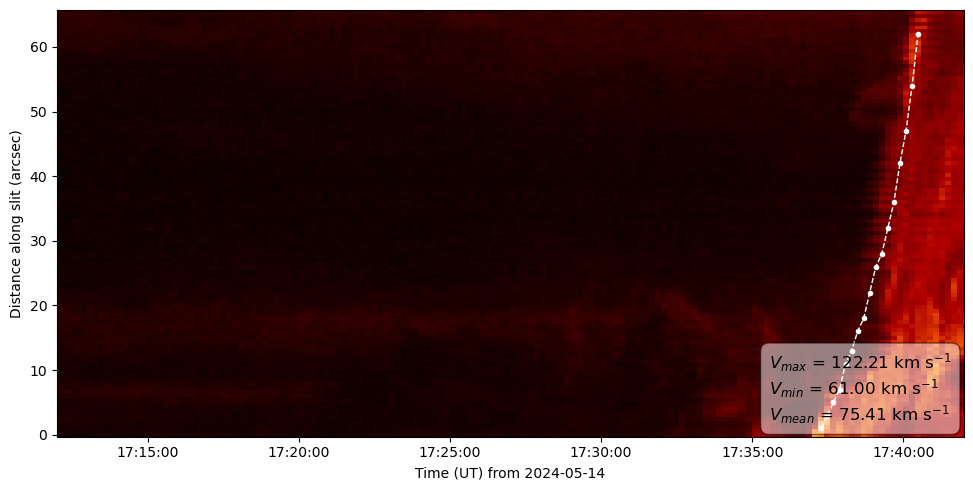

In [447]:
fig, ax = plt.subplots(figsize=[10,5])
ax.pcolormesh(time_array,
              distance,
              concatenated_array,
              norm=ImageNormalize(vmin=0, vmax=400, stretch=AsinhStretch()),
              cmap=sdoaia304
             )
ax.plot(df['time'], df['distance'], 'wo--', linewidth=1, markersize=3)

textstr = (rf'$V_{{max}}$ = {max_speed:.2f} km s$^{{-1}}$' + '\n'
           rf'$V_{{min}}$ = {min_speed:.2f} km s$^{{-1}}$' + '\n'
           rf'$V_{{mean}}$ = {avg_speed:.2f} km s$^{{-1}}$')

# Add the text to the plot using ax.text() at the desired location (x, y)
# loop 1: 0.025, 0.95
# loop 2: 0.77, 0.95
ax.text(0.785, 0.2, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))

# ax.legend(loc='upper left')
ax.set_ylabel('Distance along slit (arcsec)')
ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

ax.set_xlim(left=pd.Timestamp('2024-05-14 17:12:00'),
           right=pd.Timestamp('2024-05-14 17:42:00'))

fig.tight_layout()
plt.show()

### Do it in a for loop

In [449]:
segments = {
    'x1': [10, 80, 92, 107],
    'y1': [80, 110, 115, 155],
    'x2': [80, 50, 107, 80],
    'y2': [110, 90, 155, 135], 
    'control1': [ [45,60], [55,160], [105,145], [115,195] ],
    'control2': [ [97,70], [15,125], [95,115], [45,170] ]
}

vortex_segments_coords = {
    'seg1_x': [],
    'seg1_y': [],
    
    'seg2_x': [],
    'seg2_y': [],
    
    'seg3_x': [],
    'seg3_y': [],
    
    'seg4_x': [],
    'seg4_y': []
}

jplots = {
    'time': [],
    
    'dist_s1': [],
    'dist_s2': [],
    'dist_s3': [],
    'dist_s4': [],

    'data_s1': [],
    'data_s2': [],
    'data_s3': [],
    'data_s4': []
}

fit_line_coords = {
    'x1': [85, 121, 167, 182],
    'x2': [115, 144, 181, 199],
    'y1': [50, 0, 0, 0],
    'y2': [75.6, 76.8, 33, 65.4],
    'control1': [ [105,60], [135,30], [180,20], [195,25]],
    'control2': [ [np.nan,np.nan], [145,40], [np.nan,np.nan], [np.nan,np.nan] ]
}

In [303]:
i = 0

# track how intensity evolves along the slit over the sequence of solar images
time_array = []
intensity_stack = []

with tqdm(total=len(map_objects), desc='Stack intensities ...') as pbar:
    for m in map_objects:
        # extract the map time
        time_array.append(m.date.datetime)
        # crop the region of interest
        top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
        bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
        m_submap = m.submap(bottom_left, top_right=top_right)
        # convert the submap to an array
        subimage = m_submap.data.astype(np.float64)
        # extract the curved slit coords in pixels
        _, x_coords, y_coords = myfuncs.extract_bezier_values(subimage,
                                                           segments['x1'][i],
                                                           segments['y1'][i],
                                                           segments['x2'][i],
                                                           segments['y2'][i],
                                                           [
                                                               segments['control1'][i],
                                                               segments['control2'][i]
                                                           ],
                                                           n=3)
        # store the x & y coords of the slit
        vortex_segments_coords[f'seg{i+1}_x'] = x_coords
        vortex_segments_coords[f'seg{i+1}_y'] = y_coords
        # convert pixel coordinates to world coordinates
        slit = m_submap.pixel_to_world(x_coords * u.pixel, y_coords * u.pixel)
        # extract and stack intensity along the slit
        with SphericalScreen(m.observer_coordinate):
            slit_pixelated = sunpy.map.pixelate_coord_path(m_submap, slit)
        # slit_distance = slit_pixelated.separation(slit_pixelated[0])
        angular_distances = slit_pixelated[:-1].separation(slit_pixelated[1:])
        # Compute the cumulative sum of the angular distances
        cumulative_distances = np.cumsum(angular_distances)
        # Add 0 at the start to represent the distance at the first point
        cumulative_distances_with_start = np.insert(cumulative_distances, 0, 0*u.arcsec)
        # sample the intensity at those coords
        intensity = sunpy.map.sample_at_coords(m_submap, slit_pixelated)
        # interpolate intensity along angular distance
        f_interp = interp1d(cumulative_distances_with_start, intensity.value, fill_value='extrapolate', kind='linear')
        intensity_interp = f_interp(cumulative_distances_with_start)
        # add the intensity array to the list
        intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
        pbar.update(1)

# get the distance along slit in arcsec
distance = cumulative_distances_with_start.to(u.arcsec).value
concatenated_array = np.vstack(intensity_stack).value.T

# store data of J-plot
jplot['time'] = time_array
jplot[f'dist_s{i+1}'] = distance
jplot[f'data_s{i+1}'].append(concatenated_array)

Stack intensities ...: 100%|████████████████████████████████████████| 592/592 [01:37<00:00,  6.07it/s]


In [304]:
len(np.array(time_array)[vortex_segments_coords[f'seg{i+1}_x']]), len(vortex_segments_coords[f'seg{i+1}_y'])

(50, 50)

In [305]:
_, xfit_coords, yfit_coords = myfuncs.extract_bezier_values(concatenated_array,
                                                      fit_line_coords['x1'][i],
                                                      fit_line_coords['y1'][i],
                                                      fit_line_coords['x2'][i],
                                                      fit_line_coords['y2'][i],
                                                      [
                                                          fit_line_coords['control1'][i],
                                                          fit_line_coords['control2'][i]
                                                      ],
                                                      n=3)

array([10, 12, 14, 17, 19, 21, 23, 26, 28, 30, 33, 35, 38, 40, 42, 44, 47,
       49, 51, 53, 56, 58, 60, 62, 64, 65, 67, 69, 71, 72, 74, 75, 76, 78,
       79, 80, 81, 81, 82, 83, 83, 83, 83, 83, 83, 83, 82, 82, 81, 80])

,time,distance,distance_km,distance_diff_km,time_diff_s,speed_km_s
1,2024-05-14 17:02:29.130,79,57878.56948,-732.64012,24.01,-30.513958
2,2024-05-14 17:02:53.140,78,57145.92936,-732.64012,24.01,-30.513958
3,2024-05-14 17:03:29.120,77,56413.28924,-732.64012,35.98,-20.362427
4,2024-05-14 17:03:53.130,76,55680.64912,-732.64012,24.01,-30.513958
5,2024-05-14 17:04:17.130,75,54948.00900,-732.64012,24.00,-30.526672


Vmax = 122.11 km/s
Vmin = -183.16 km/s
Vavg = 4.55 km/s


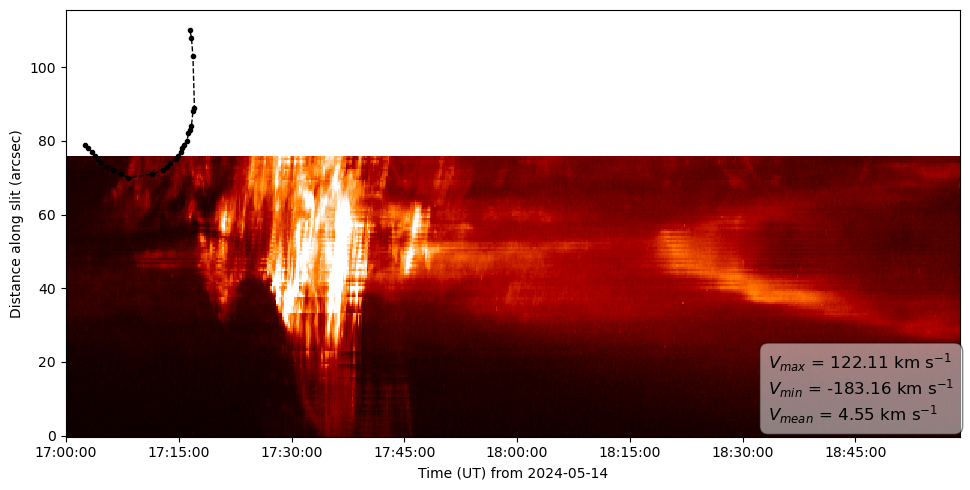

In [308]:
# calc speed in the segment
# _, x_coords, y_coords = myfuncs.extract_bezier_values(concatenated_array, x1, y1, x2, y2, [control1, control2], n=3)
# store the x & y coords of the slit
# slit_fit_coords[f'seg{i+1}_x'] = x_coords
# slit_fit_coords[f'seg{i+1}_y'] = y_coords
# df = pd.DataFrame({'time': np.array(time_array)[slit_fit_coords[f'seg{i+1}_x']],
#                    'distance': slit_fit_coords[f'seg{i+1}_y']
#                   })
df = pd.DataFrame({'time': np.array(time_array)[xfit_coords],
                   'distance': yfit_coords
                  })
# get the radius of the solar disk
sol_rad = const.equatorial_radius.to(u.km)
# conversion factor from arcsec to km
conversion_factor = sol_rad/m.rsun_obs
# convert distance from arcsec to km
df['distance_km'] = df['distance'] * conversion_factor.value
# calculate the distance difference in km
df['distance_diff_km'] = df['distance_km'].diff()
# calculate the time difference in seconds
df['time_diff_s'] = df['time'].diff().dt.total_seconds()
# calculate the speed in km/s
df['speed_km_s'] = df['distance_diff_km'] / df['time_diff_s']
# drop the first row which will have NaN values for the differences
df.dropna(inplace=True)
# Filter out rows where time_diff_s is 0 and speed_km_s is inf
df = df[~((df['time_diff_s'] == 0) & (df['speed_km_s'] == np.inf))]
# Filter out rows where speed_km_s is zero
df = df[~(df['speed_km_s'] == 0)]
display(df.head())
# calc speeds stats
max_speed = np.nanmax(df['speed_km_s'])
min_speed = np.nanmin(df['speed_km_s'])
avg_speed = np.nanmean(df['speed_km_s'])

print(f'Vmax = {max_speed:.2f} km/s')
print(f'Vmin = {min_speed:.2f} km/s')
print(f'Vavg = {avg_speed:.2f} km/s')

# Add the text to the plot using ax.text() at the desired location (x, y)
textstr = (rf'$V_{{max}}$ = {max_speed:.2f} km s$^{{-1}}$' + '\n'
           rf'$V_{{min}}$ = {min_speed:.2f} km s$^{{-1}}$' + '\n'
           rf'$V_{{mean}}$ = {avg_speed:.2f} km s$^{{-1}}$')

# plot the J-plot
fig, ax = plt.subplots(figsize=[10,5])
ax.pcolormesh(time_array,
              distance,
              concatenated_array,
              norm=ImageNormalize(vmin=0, vmax=400, stretch=AsinhStretch()),
              cmap=sdoaia304
             )
ax.plot(df['time'], df['distance'], 'ko--', linewidth=1, markersize=3)
ax.text(0.785, 0.2, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))
ax.set_ylabel('Distance along slit (arcsec)')
ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.tight_layout()
plt.show()

In [ ]:
m = map_objects[177] # loop_1: 177, loop_2: 200
norm = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch())
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)
subimage = m_submap.data.astype(np.float64)

color_set = ['black', 'yellow', 'blue', 'white']

# plot the loop with the slit points
fig = plt.figure(figsize=[7,10])
ax = fig.add_subplot(projection=m_submap)
m_submap.plot(axes=ax, norm=norm)

for i in range(4):
    _, x_coords, y_coords = myfuncs.extract_bezier_values(subimage,
                                                               segments['x1'][i],
                                                               segments['y1'][i],
                                                               segments['x2'][i],
                                                               segments['y2'][i],
                                                               [
                                                                   segments['control1'][i],
                                                                   segments['control2'][i]
                                                               ],
                                                               n=3)
    # convert pixel coordinates to world coordinates
    slit = m_submap.pixel_to_world(x_coords * u.pixel, y_coords * u.pixel)
    ax.plot_coord(slit, 'o-', color=color_set[i], markersize=4, label=f'S {i+1}')

ax.grid(False)
ax.legend(loc='upper left')
fig.tight_layout()
plt.show()

Stack intensities of J-plot 4 ...: 100%|████████████████████████████| 592/592 [01:37<00:00,  6.05it/s]


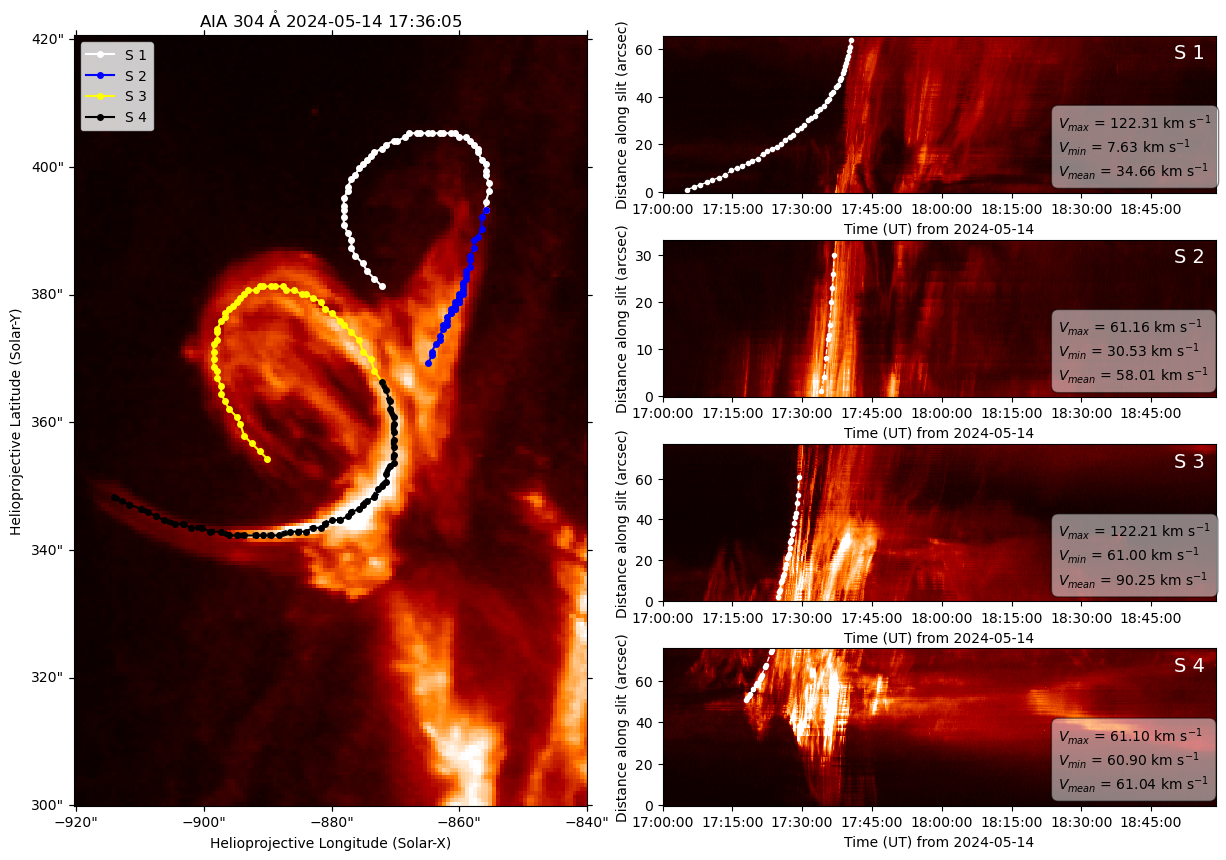

In [458]:
m = map_objects[177] # loop_1: 177, loop_2: 200
norm = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch())
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)
subimage = m_submap.data.astype(np.float64)

# segments = {
#     'x1': [10, 80, 92, 107],
#     'y1': [80, 110, 115, 155],
#     'x2': [80, 50, 107, 80],
#     'y2': [110, 90, 155, 135], 
#     'control1': [ [45,60], [55,160], [105,145], [115,195] ],
#     'control2': [ [97,70], [15,125], [95,115], [45,170] ]
# }

# vortex_segments_coords = {
#     'seg1_x': [],
#     'seg1_y': [],
    
#     'seg2_x': [],
#     'seg2_y': [],
    
#     'seg3_x': [],
#     'seg3_y': [],
    
#     'seg4_x': [],
#     'seg4_y': []
# }

# jplots = {
#     'time': [],
    
#     'dist_s1': [],
#     'dist_s2': [],
#     'dist_s3': [],
#     'dist_s4': [],

#     'data_s1': [],
#     'data_s2': [],
#     'data_s3': [],
#     'data_s4': []
# }

# fit_line_coords = {
#     'x1': [85, 121, 167, 182],
#     'x2': [115, 144, 181, 199],
#     'y1': [50, 0, 0, 0],
#     'y2': [75.6, 76.8, 33, 65.4],
#     'control1': [ [105,60], [135,30], [180,20], [195,25]],
#     'control2': [ [np.nan,np.nan], [145,40], [np.nan,np.nan], [np.nan,np.nan] ]
# }

# color_set  = ['white', 'blue', 'yellow', 'black']


segments = {
    'x1': [107, 92, 80, 10],
    'y1': [155, 115, 110, 80],
    'x2': [80, 107, 50, 80],
    'y2': [135, 155, 90, 110], 
    'control1': [ [115,195], [105,145], [55,160], [45,60] ],
    'control2': [ [45,170], [95,115], [15,125], [97,70] ]
}

vortex_segments_coords = {
    'seg1_x': [],
    'seg1_y': [],
    
    'seg2_x': [],
    'seg2_y': [],
    
    'seg3_x': [],
    'seg3_y': [],
    
    'seg4_x': [],
    'seg4_y': []
}

jplots = {
    'time': [],
    
    'dist_s1': [],
    'dist_s2': [],
    'dist_s3': [],
    'dist_s4': [],

    'data_s1': [],
    'data_s2': [],
    'data_s3': [],
    'data_s4': []
}

x1 = 140
x2 = 167
y1 = fit_line_coords['y1'][i]
y2 = fit_line_coords['y2'][i]
control1 = [161, 15]

fit_line_coords = {
    'x1': [182, 167, 121, 85],
    'x2': [199, 181, 144, 115],
    'y1': [0, 0, 0, 50],
    'y2': [65.4, 33, 76.8, 75.6],
    'control1': [ [195,25], [180,20], [135,30], [105,60] ],
    'control2': [ [np.nan,np.nan], [np.nan,np.nan], [145,40], [np.nan,np.nan] ]
}

# color_set  = ['black', 'yellow', 'blue', 'white']
color_set  = ['white', 'blue', 'yellow', 'black']

speeds = []
speed_stats = {
    'vmax': [],
    'vmin': [],
    'vavg': []
}

# Create a figure with gridspec layout
fig = plt.figure(figsize=[15,10])  # Adjust the figure size as needed
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.1)  # 2 columns: Left plot wider than right panels

# Left plot (larger, spans entire left side)
ax_left = fig.add_subplot(gs[0, 0], projection=m_submap)
m_submap.plot(axes=ax_left, norm=norm)
ax_left.plot_coord(slit, color='k', ls=':', lw=4)

for i in range(4):
    _, x_coords, y_coords = myfuncs.extract_bezier_values(subimage,
                                                               segments['x1'][i],
                                                               segments['y1'][i],
                                                               segments['x2'][i],
                                                               segments['y2'][i],
                                                               [
                                                                   segments['control1'][i],
                                                                   segments['control2'][i]
                                                               ],
                                                               n=3)
    # convert pixel coordinates to world coordinates
    slit = m_submap.pixel_to_world(x_coords * u.pixel, y_coords * u.pixel)
    ax_left.plot_coord(slit, 'o-', color=color_set[i], markersize=4, label=f'S {i+1}')

ax_left.grid(False)
ax_left.legend(loc='upper left')

# Create a GridSpec within the right side for the 4 stacked panels
gs_right = gs[0, 1].subgridspec(4, 1, hspace=0.2)  # 4 rows, 1 column

# track how intensity evolves along the slit over the sequence of solar images
for i in range(4):
    time_array = []
    intensity_stack = []
    
    with tqdm(total=len(map_objects), desc=f'Stack intensities of J-plot {i+1} ...') as pbar:
        for m in map_objects:
            # extract the map time
            time_array.append(m.date.datetime)
            # crop the region of interest
            top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
            bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
            m_submap = m.submap(bottom_left, top_right=top_right)
            # convert the submap to an array
            subimage = m_submap.data.astype(np.float64)
            # extract the curved slit coords in pixels
            _, x_coords, y_coords = myfuncs.extract_bezier_values(subimage,
                                                               segments['x1'][i],
                                                               segments['y1'][i],
                                                               segments['x2'][i],
                                                               segments['y2'][i],
                                                               [
                                                                   segments['control1'][i],
                                                                   segments['control2'][i]
                                                               ],
                                                               n=3)
            # store the x & y coords of the slit
            vortex_segments_coords[f'seg{i+1}_x'] = x_coords
            vortex_segments_coords[f'seg{i+1}_y'] = y_coords
            # convert pixel coordinates to world coordinates
            slit = m_submap.pixel_to_world(x_coords * u.pixel, y_coords * u.pixel)
            # extract and stack intensity along the slit
            with SphericalScreen(m.observer_coordinate):
                slit_pixelated = sunpy.map.pixelate_coord_path(m_submap, slit)
            # slit_distance = slit_pixelated.separation(slit_pixelated[0])
            angular_distances = slit_pixelated[:-1].separation(slit_pixelated[1:])
            # Compute the cumulative sum of the angular distances
            cumulative_distances = np.cumsum(angular_distances)
            # Add 0 at the start to represent the distance at the first point
            cumulative_distances_with_start = np.insert(cumulative_distances, 0, 0*u.arcsec)
            # sample the intensity at those coords
            intensity = sunpy.map.sample_at_coords(m_submap, slit_pixelated)
            # interpolate intensity along angular distance
            f_interp = interp1d(cumulative_distances_with_start, intensity.value, fill_value='extrapolate', kind='linear')
            intensity_interp = f_interp(cumulative_distances_with_start)
            # add the intensity array to the list
            intensity_stack.append(u.Quantity(intensity_interp, intensity.unit))
            pbar.update(1)
    
    # get the distance along slit in arcsec
    distance = cumulative_distances_with_start.to(u.arcsec).value
    concatenated_array = np.vstack(intensity_stack).value.T
    
    # store data of J-plot
    jplots['time'] = time_array
    jplots[f'dist_s{i+1}'] = distance
    jplots[f'data_s{i+1}'].append(concatenated_array)
    
    # calc speed in the segment
    _, xfit_coords, yfit_coords = myfuncs.extract_bezier_values(concatenated_array,
                                                   fit_line_coords['x1'][i],
                                                   fit_line_coords['y1'][i],
                                                   fit_line_coords['x2'][i],
                                                   fit_line_coords['y2'][i],
                                                   [
                                                       fit_line_coords['control1'][i],
                                                       fit_line_coords['control2'][i]
                                                   ],
                                                   n=3)
    df = pd.DataFrame({'time': np.array(time_array)[xfit_coords],
                       'distance': yfit_coords
                      })
    # get the radius of the solar disk
    sol_rad = const.equatorial_radius.to(u.km)
    # conversion factor from arcsec to km
    conversion_factor = sol_rad/m.rsun_obs
    # convert distance from arcsec to km
    df['distance_km'] = df['distance'] * conversion_factor.value
    # calculate the distance difference in km
    df['distance_diff_km'] = df['distance_km'].diff()
    # calculate the time difference in seconds
    df['time_diff_s'] = df['time'].diff().dt.total_seconds()
    # calculate the speed in km/s
    df['speed_km_s'] = df['distance_diff_km'] / df['time_diff_s']
    # drop the first row which will have NaN values for the differences
    df.dropna(inplace=True)
    # Filter out rows where time_diff_s is 0 and speed_km_s is inf
    df = df[~((df['time_diff_s'] == 0) & (df['speed_km_s'] == np.inf))]
    # Filter out rows where speed_km_s is zero
    df = df[~(df['speed_km_s'] == 0)]
    # calc speeds stats
    max_speed = np.nanmax(df['speed_km_s'])
    min_speed = np.nanmin(df['speed_km_s'])
    avg_speed = np.nanmean(df['speed_km_s'])

    speeds.append(df)
    speed_stats['vmax'].append(max_speed)
    speed_stats['vmin'].append(min_speed)
    speed_stats['vavg'].append(avg_speed)
    
    # Add the text to the plot using ax.text() at the desired location (x, y)
    textstr = (rf'$V_{{max}}$ = {max_speed:.2f} km s$^{{-1}}$' + '\n'
               rf'$V_{{min}}$ = {min_speed:.2f} km s$^{{-1}}$' + '\n'
               rf'$V_{{mean}}$ = {avg_speed:.2f} km s$^{{-1}}$')
    
    # plot the J-plot
    ax = fig.add_subplot(gs_right[i, 0])
    ax.pcolormesh(time_array,
                  distance,
                  concatenated_array,
                  norm=ImageNormalize(vmin=0, vmax=400, stretch=AsinhStretch()),
                  cmap=sdoaia304
                 )
    ax.plot(df['time'], df['distance'], 'wo--', linewidth=1, markersize=3)
    
    ax.text(0.98, 0.95, f'S {i+1}', horizontalalignment='right', color='w',
        verticalalignment='top', transform=ax.transAxes, fontsize=14)

    ax.text(0.715, 0.512, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))

    ax.set_ylabel('Distance along slit (arcsec)')
    ax.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

fig.tight_layout()
plt.show()

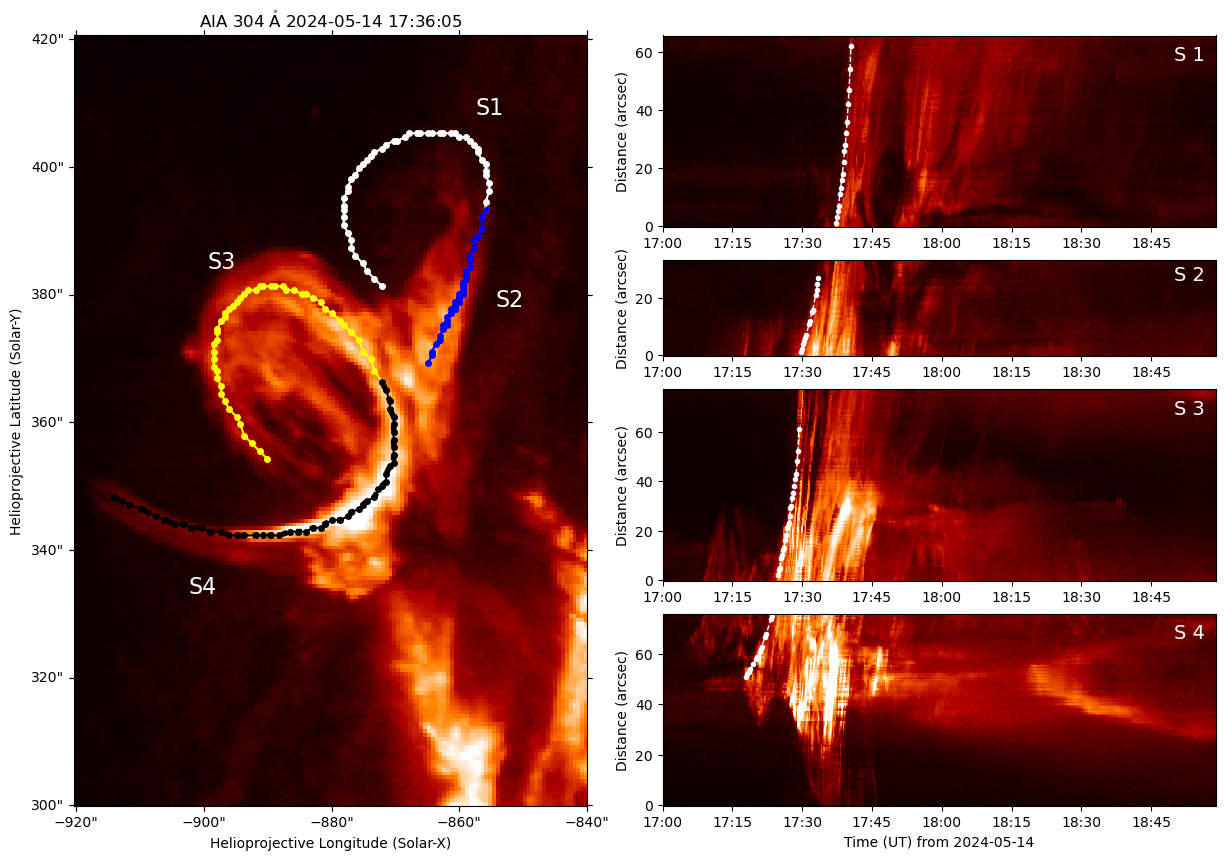

In [562]:
# Test ...

m = map_objects[177] # loop_1: 177, loop_2: 200
norm = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch())
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)
subimage = m_submap.data.astype(np.float64)

segments = {
    'x1': [107, 92, 80, 10],
    'y1': [155, 115, 110, 80],
    'x2': [80, 107, 50, 80],
    'y2': [135, 155, 90, 110], 
    'control1': [ [115,195], [105,145], [55,160], [45,60] ],
    'control2': [ [45,170], [95,115], [15,125], [97,70] ]
}
fit_line_coords = {
    'x1': [182, 145, 121, 85],
    'x2': [199, 167, 144, 115],
    'y1': [0, 0, 0, 50],
    'y2': [65.4, 33, 76.8, 75.6],
    'control1': [ [195,25], [161,15], [135,30], [105,60] ],
    'control2': [ [np.nan,np.nan], [np.nan,np.nan], [145,40], [np.nan,np.nan] ]
}
color_set  = ['white', 'blue', 'yellow', 'black']
labels = {'S1': (95/m_submap.data.shape[1], 185/m_submap.data.shape[0]),
          'S2': (110/m_submap.data.shape[1], 135/m_submap.data.shape[0]),
          'S3': (35/m_submap.data.shape[1], 150/m_submap.data.shape[0]),
          'S4': (30/m_submap.data.shape[1], 60/m_submap.data.shape[0])}
speeds = []
speed_stats = {
    'vmax': [],
    'vmin': [],
    'vavg': []
}

# Make a figure with gridspec layout
fig = plt.figure(figsize=[15,10])  # Adjust the figure size as needed
gs = fig.add_gridspec(1, 2, # 2 columns: Left plot wider than right panels
                      width_ratios=[1, 1], wspace=0.1)

# Left plot (larger, spans entire left side)
ax_left = fig.add_subplot(gs[0, 0], projection=m_submap)
m_submap.plot(axes=ax_left, norm=norm)
ax_left.plot_coord(slit, color='k', ls=':', lw=4)

for i in range(4):
    _, x_coords, y_coords = myfuncs.extract_bezier_values(subimage,
                                                               segments['x1'][i],
                                                               segments['y1'][i],
                                                               segments['x2'][i],
                                                               segments['y2'][i],
                                                               [
                                                                   segments['control1'][i],
                                                                   segments['control2'][i]
                                                               ],
                                                               n=3)
    # convert pixel coordinates to world coordinates
    slit = m_submap.pixel_to_world(x_coords * u.pixel, y_coords * u.pixel)
    ax_left.plot_coord(slit, 'o-', color=color_set[i], markersize=4,
                       # label=f'S {i+1}'
                      )
    ax_left.text(labels[f'S{i+1}'][0], labels[f'S{i+1}'][1], f'S{i+1}',
                 transform=ax_left.transAxes, fontsize=16, color='w',
                 horizontalalignment='left', verticalalignment='top')

ax_left.grid(False)
# ax_left.legend(loc='upper left')

# Make a GridSpec within the right side for the 4 stacked panels
# Adjust height_ratios to make S2 half the height of others
gs_right = gs[0, 1].subgridspec(4, 1, hspace=0.2, height_ratios=[1, 0.5, 1, 1])

# track how intensity evolves along the slit over the sequence of solar images
for i in range(4):   
    # calc speed in the segment
    _, xfit_coords, yfit_coords = myfuncs.extract_bezier_values(jplots[f'data_s{i+1}'][0],
                                                   fit_line_coords['x1'][i],
                                                   fit_line_coords['y1'][i],
                                                   fit_line_coords['x2'][i],
                                                   fit_line_coords['y2'][i],
                                                   [
                                                       fit_line_coords['control1'][i],
                                                       fit_line_coords['control2'][i]
                                                   ],
                                                   n=3)
    df = pd.DataFrame({'time': np.array(jplots['time'])[xfit_coords],
                       'distance': yfit_coords
                      })
    # get the radius of the solar disk
    sol_rad = const.equatorial_radius.to(u.km)
    # conversion factor from arcsec to km
    conversion_factor = sol_rad/m.rsun_obs
    # convert distance from arcsec to km
    df['distance_km'] = df['distance'] * conversion_factor.value
    # calculate the distance difference in km
    df['distance_diff_km'] = df['distance_km'].diff()
    # calculate the time difference in seconds
    df['time_diff_s'] = df['time'].diff().dt.total_seconds()
    # calculate the speed in km/s
    df['speed_km_s'] = df['distance_diff_km'] / df['time_diff_s']
    # drop the first row which will have NaN values for the differences
    df.dropna(inplace=True)
    # Filter out rows where time_diff_s is 0 and speed_km_s is inf
    df = df[~((df['time_diff_s'] == 0) & (df['speed_km_s'] == np.inf))]
    # Filter out rows where speed_km_s is zero
    df = df[~(df['speed_km_s'] == 0)]
    # calc speeds stats
    max_speed = np.nanmax(df['speed_km_s'])
    min_speed = np.nanmin(df['speed_km_s'])
    avg_speed = np.nanmean(df['speed_km_s'])

    speeds.append(df)
    speed_stats['vmax'].append(max_speed)
    speed_stats['vmin'].append(min_speed)
    speed_stats['vavg'].append(avg_speed)
    
    # Add the text to the plot using ax.text() at the desired location (x, y)
    textstr = (rf'$V_{{max}}$ = {max_speed:.2f} km s$^{{-1}}$' + '\n'
               rf'$V_{{min}}$ = {min_speed:.2f} km s$^{{-1}}$' + '\n'
               rf'$V_{{mean}}$ = {avg_speed:.2f} km s$^{{-1}}$')
    
    # plot the J-plot
    ax = fig.add_subplot(gs_right[i, 0])
    ax.pcolormesh(jplots['time'],
                  jplots[f'dist_s{i+1}'],
                  jplots[f'data_s{i+1}'][0],
                  norm=ImageNormalize(vmin=0, vmax=400, stretch=AsinhStretch()),
                  cmap=sdoaia304
                 )
    ax.plot(df['time'], df['distance'], 'wo--', linewidth=1, markersize=3)
    ax.text(0.98, 0.95, f'S {i+1}', horizontalalignment='right', color='w',
        verticalalignment='top', transform=ax.transAxes, fontsize=14)
    # ax.text(0.706, 0.512, textstr, transform=ax.transAxes, fontsize=10,
    #         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))
    ax.set_ylabel('Distance (arcsec)')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    if i == max(range(4)):
        ax.set_xlabel(f"Time (UT) from {jplots['time'][0].strftime('%Y-%m-%d')}")

fig.tight_layout()
# fig.savefig(f'{data_dir}/tornado_jmaps.pdf', format='pdf', bbox_inches='tight')
# fig.savefig(f'{data_dir}/png/tornado/tornado_jmaps.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

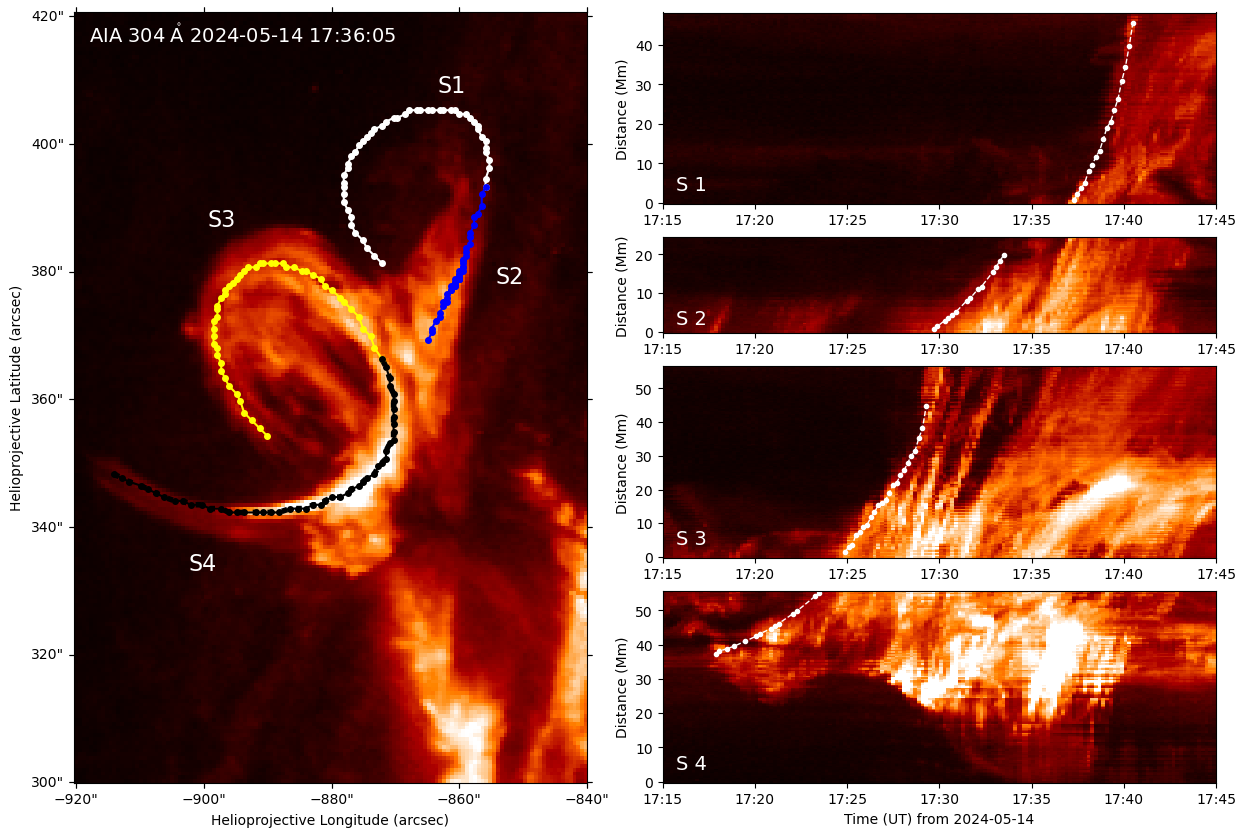

In [635]:
# Test ...

m = map_objects[177] # loop_1: 177, loop_2: 200
norm = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch())
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)
subimage = m_submap.data.astype(np.float64)

segments = {
    'x1': [107, 92, 80, 10],
    'y1': [155, 115, 110, 80],
    'x2': [80, 107, 50, 80],
    'y2': [135, 155, 90, 110], 
    'control1': [ [115,195], [105,145], [55,160], [45,60] ],
    'control2': [ [45,170], [95,115], [15,125], [97,70] ]
}
fit_line_coords = {
    'x1': [182, 145, 121, 85],
    'x2': [199, 167, 144, 115],
    'y1': [0, 0, 0, 50],
    'y2': [65.4, 33, 76.8, 75.6],
    'control1': [ [195,25], [161,15], [135,30], [105,60] ],
    'control2': [ [np.nan,np.nan], [np.nan,np.nan], [145,40], [np.nan,np.nan] ]
}
color_set  = ['white', 'blue', 'yellow', 'black']
labels = {'S1': (95/m_submap.data.shape[1], 185/m_submap.data.shape[0]),
          'S2': (110/m_submap.data.shape[1], 135/m_submap.data.shape[0]),
          'S3': (35/m_submap.data.shape[1], 150/m_submap.data.shape[0]),
          'S4': (30/m_submap.data.shape[1], 60/m_submap.data.shape[0])}
speeds = []
speed_stats = {
    'vmax': [],
    'vmin': [],
    'vavg': []
}

# Make a figure with gridspec layout
fig = plt.figure(figsize=[15,10])  # Adjust the figure size as needed
gs = fig.add_gridspec(1, 2, # 2 columns: Left plot wider than right panels
                      width_ratios=[1, 1], wspace=0.1)

# Left plot (larger, spans entire left side)
ax_left = fig.add_subplot(gs[0, 0], projection=m_submap)
m_submap.plot(axes=ax_left, norm=norm)
ax_left.plot_coord(slit, color='k', ls=':', lw=4)

for i in range(4):
    _, x_coords, y_coords = myfuncs.extract_bezier_values(subimage,
                                                               segments['x1'][i],
                                                               segments['y1'][i],
                                                               segments['x2'][i],
                                                               segments['y2'][i],
                                                               [
                                                                   segments['control1'][i],
                                                                   segments['control2'][i]
                                                               ],
                                                               n=3)
    # convert pixel coordinates to world coordinates
    slit = m_submap.pixel_to_world(x_coords * u.pixel, y_coords * u.pixel)
    ax_left.plot_coord(slit, 'o-', color=color_set[i], markersize=4,
                       # label=f'S {i+1}'
                      )
    ax_left.text(labels[f'S{i+1}'][0], labels[f'S{i+1}'][1], f'S{i+1}',
                 transform=ax_left.transAxes, fontsize=16, color='w',
                 horizontalalignment='left', verticalalignment='top')

ax_left.grid(False)
# ax_left.legend(loc='upper left')
ax_left.set_title('')
ax_left.set_xlabel('Helioprojective Longitude (arcsec)')
ax_left.set_ylabel('Helioprojective Latitude (arcsec)')
ax_left.text(0.03, 0.987, m_submap.latex_name, transform=ax_left.transAxes,
             fontsize=14, color='w', verticalalignment='top')

# Make a GridSpec within the right side for the 4 stacked panels
# Adjust height_ratios to make S2 half the height of others
gs_right = gs[0, 1].subgridspec(4, 1, hspace=0.2, height_ratios=[1, 0.5, 1, 1])

# track how intensity evolves along the slit over the sequence of solar images
kinematics = []
for i in range(4):   
    # calc speed in the segment
    _, xfit_coords, yfit_coords = myfuncs.extract_bezier_values(jplots[f'data_s{i+1}'][0],
                                                   fit_line_coords['x1'][i],
                                                   fit_line_coords['y1'][i],
                                                   fit_line_coords['x2'][i],
                                                   fit_line_coords['y2'][i],
                                                   [
                                                       fit_line_coords['control1'][i],
                                                       fit_line_coords['control2'][i]
                                                   ],
                                                   n=3)
    df = pd.DataFrame({'time': np.array(jplots['time'])[xfit_coords],
                       'distance': yfit_coords
                      })
    # get the radius of the solar disk
    sol_rad = const.equatorial_radius.to(u.km)
    # conversion factor from arcsec to km
    conversion_factor = sol_rad/m.rsun_obs
    # convert distance from arcsec to km
    df['distance_km'] = df['distance'] * conversion_factor.value
    # calculate the distance difference in km
    df['distance_diff_km'] = df['distance_km'].diff()
    # calculate the time difference in seconds
    df['time_diff_s'] = df['time'].diff().dt.total_seconds()
    # calculate the speed in km/s
    df['speed_km_s'] = df['distance_diff_km'] / df['time_diff_s']
    # calculate the accel. m/s2
    # speed_m_s      = df['speed_km_s']*1e3
    # speed_diff_m_s = speed_m_s.diff()
    # accel_m_s2     = speed_diff_m_s/df['time_diff_s']
    # store speed and accel. in a single df
    tmp_df = pd.DataFrame({'time': df['time'],
                           'time_diff_s': df['time_diff_s'],
                           'speed_km_s': df['speed_km_s'],
                           # 'accel_m_s2': accel_m_s2}))
                          })
    tmp_df.dropna(inplace=True)
    tmp_df = tmp_df[~((tmp_df['time_diff_s'] == 0) & (tmp_df['speed_km_s'] == np.inf))]
    tmp_df = tmp_df[~(tmp_df['speed_km_s'] == 0)]
    tmp_df['speed_m_s']      = tmp_df['speed_km_s']*1e3
    tmp_df['speed_diff_m_s'] = tmp_df['speed_m_s'].diff()
    tmp_df['accel_m_s2']     = tmp_df['speed_diff_m_s']/tmp_df['time_diff_s']
    kinematics.append(tmp_df)
    # drop the first row which will have NaN values for the differences
    df.dropna(inplace=True)
    # Filter out rows where time_diff_s is 0 and speed_km_s is inf
    df = df[~((df['time_diff_s'] == 0) & (df['speed_km_s'] == np.inf))]
    # Filter out rows where speed_km_s is zero
    df = df[~(df['speed_km_s'] == 0)]
    # calc speeds stats
    max_speed = np.nanmax(df['speed_km_s'])
    min_speed = np.nanmin(df['speed_km_s'])
    avg_speed = np.nanmean(df['speed_km_s'])

    speeds.append(df)
    speed_stats['vmax'].append(max_speed)
    speed_stats['vmin'].append(min_speed)
    speed_stats['vavg'].append(avg_speed)
    
    # Add the text to the plot using ax.text() at the desired location (x, y)
    textstr = (rf'$V_{{max}}$ = {max_speed:.2f} km s$^{{-1}}$' + '\n'
               rf'$V_{{min}}$ = {min_speed:.2f} km s$^{{-1}}$' + '\n'
               rf'$V_{{mean}}$ = {avg_speed:.2f} km s$^{{-1}}$')
    
    # convert from arcsec to solar radius
    dist_rsun = (df['distance'].values*u.arcsec) / m_submap.rsun_obs
    # convert from solar radius to Mm
    dist_rsun = dist_rsun*u.R_sun
    dist_Mm   = dist_rsun.to('Mm')
    
    # convert from arcsec to solar radius
    jplot_dist_rsun = (jplots[f'dist_s{i+1}']*u.arcsec) / m_submap.rsun_obs
    # convert from solar radius to Mm
    jplot_dist_rsun = jplot_dist_rsun*u.R_sun
    jplot_dist_Mm   = jplot_dist_rsun.to('Mm')
    
    # plot the J-plot
    ax = fig.add_subplot(gs_right[i, 0])
    ax.pcolormesh(jplots['time'],
                  jplot_dist_Mm.value,
                  jplots[f'data_s{i+1}'][0],
                  norm=ImageNormalize(vmin=0, vmax=400, stretch=AsinhStretch()),
                  cmap=sdoaia304
                 )
    ax.plot(df['time'], dist_Mm.value, 'wo--', linewidth=1, markersize=3)
    # ax.text(0.98, 0.95, f'S {i+1}', horizontalalignment='right', color='w',
    #     verticalalignment='top', transform=ax.transAxes, fontsize=14)
    ax.text(0.025, 0.05, f'S {i+1}', horizontalalignment='left', color='w',
        verticalalignment='bottom', transform=ax.transAxes, fontsize=14)
    # ax.text(0.706, 0.512, textstr, transform=ax.transAxes, fontsize=10,
    #         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))
    ax.set_ylabel('Distance (Mm)')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_xlim(left=pd.Timestamp('2024-05-14 17:15'),
                right=pd.Timestamp('2024-05-14 17:45'))
    if i == max(range(4)):
        ax.set_xlabel(f"Time (UT) from {jplots['time'][0].strftime('%Y-%m-%d')}")

fig.tight_layout()
# fig.savefig(f'{data_dir}/tornado_jmaps.pdf', format='pdf', bbox_inches='tight')
# fig.savefig(f'{data_dir}/png/tornado/tornado_jmaps.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [656]:
df_kinematics = pd.concat(kinematics[::-1], ignore_index=True)
df_kinematics.head()

,time,time_diff_s,speed_km_s,speed_m_s,speed_diff_m_s,accel_m_s2
0,2024-05-14 17:17:53.130,12.01,61.003489,61003.489345,NaN,NaN
1,2024-05-14 17:18:05.120,11.99,61.105247,61105.246625,101.757280,8.486846
2,2024-05-14 17:18:29.160,12.03,60.902070,60902.070410,-203.176215,-16.889128
3,2024-05-14 17:18:53.130,12.00,61.054326,61054.325586,152.255176,12.687931
4,2024-05-14 17:19:29.120,11.99,61.105247,61105.246625,50.921039,4.246959


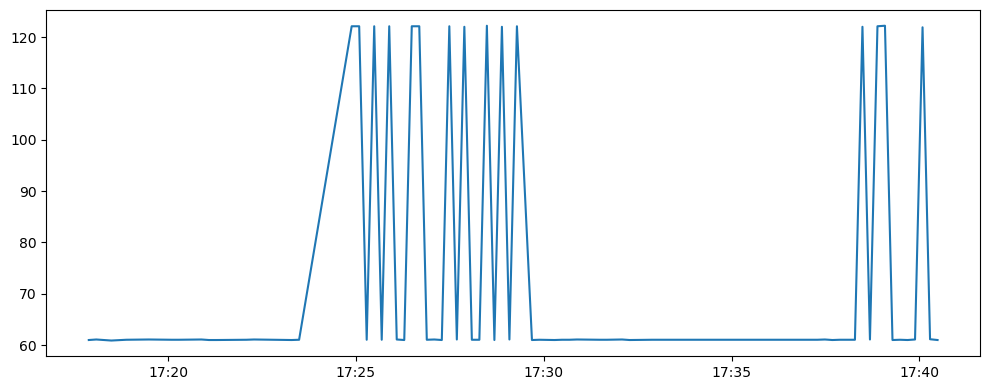

In [758]:
fig = plt.figure(figsize=[10,4])
ax = fig.add_subplot(111)
ax.plot(df_kinematics['time'], df_kinematics['speed_km_s'])
# ax.set_yscale('log')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [725]:
df_kinematics['time'].iloc[0], df_kinematics['time'].iloc[-1], df_kinematics['time'].iloc[-1] - df_kinematics['time'].iloc[0]

(Timestamp('2024-05-14 17:17:53.130000'),
 Timestamp('2024-05-14 17:40:29.140000'),
 Timedelta('0 days 00:22:36.010000'))

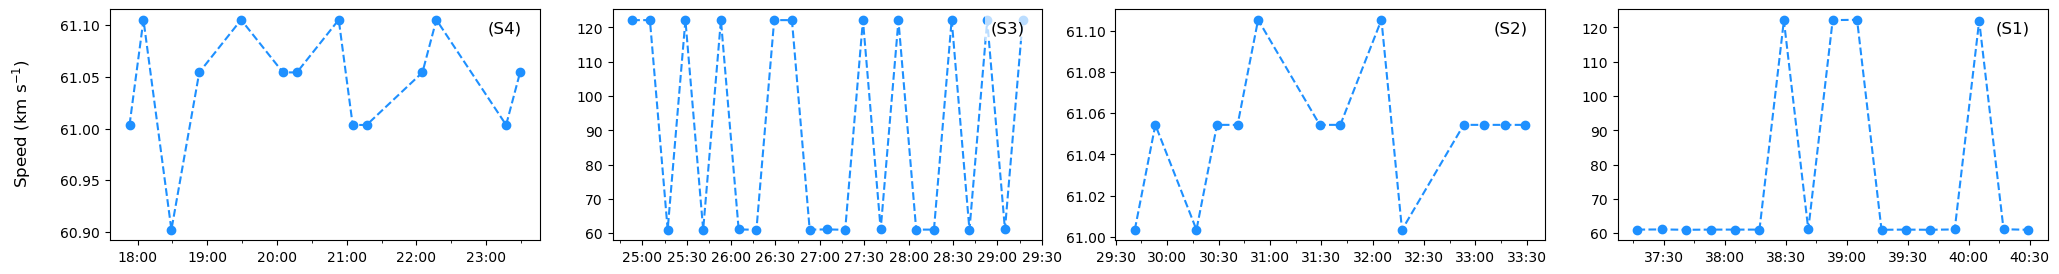

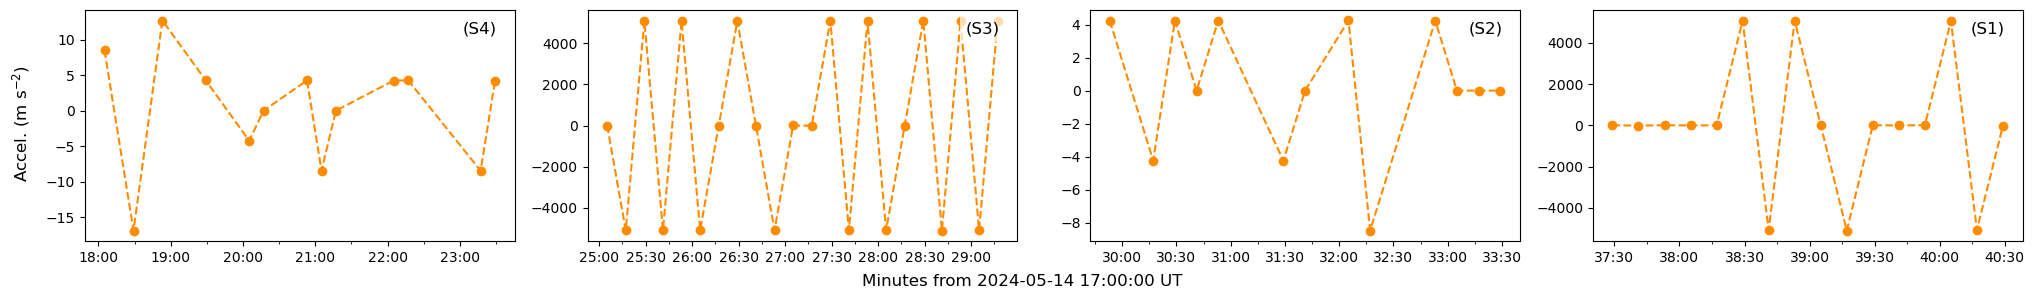

In [764]:
labels = ['(S4)','(S3)','(S2)','(S1)']
fig = plt.figure(figsize=[25,3])
fig.supylabel(r'Speed (km s$^{-1}$)', x=0.085)
for i in range(len(kinematics)):
    ax = fig.add_subplot(1, len(kinematics), i+1)
    ax.plot(kinematics[::-1][i]['time'], kinematics[::-1][i]['speed_km_s'], 'o--', color='dodgerblue')
    ax.text(0.88, 0.95, labels[i], transform=ax.transAxes, fontsize=12, color='k',
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=2))
plt.subplots_adjust(wspace=0.17)
fig.savefig(f'{data_dir}/speed_tornado.pdf', format='pdf', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=[25,3])
fig.supxlabel('Minutes from 2024-05-14 17:00:00 UT', y=-0.05)
fig.supylabel(r'Accel. (m s$^{-2}$)', x=0.095)
for i in range(len(kinematics)):
    ax = fig.add_subplot(1, len(kinematics), i+1)
    ax.plot(kinematics[::-1][i]['time'], kinematics[::-1][i]['accel_m_s2'], 'o--', color='darkorange')
    ax.text(0.88, 0.95, labels[i], transform=ax.transAxes, fontsize=12, color='k',
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    ax.xaxis.set_minor_locator(AutoMinorLocator(n=2))
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
plt.subplots_adjust(wspace=0.17)
fig.savefig(f'{data_dir}/accel_tornado.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [763]:
kinematics[0].head(2)

,time,time_diff_s,speed_km_s,speed_m_s,speed_diff_m_s,accel_m_s2
1,2024-05-14 17:37:17.130,12.00,61.054326,61054.325586,NaN,NaN
3,2024-05-14 17:37:29.120,11.99,61.105247,61105.246625,50.921039,4.246959


In [749]:
for i in range(len(kinematics)):
    ax = fig.add_subplot(1, len(kinematics), i+1)
    speed = kinematics[::-1][i]['speed_km_s']
    vmax = np.nanmax(speed)
    vavg = np.nanmean(speed)
    vmin = np.nanmin(speed)
    print(labels[i])
    print(f'Vmax = {vmax:.2f}')
    print(f'Vavg = {vavg:.2f}')
    print(f'Vmin = {vmin:.2f}\n')

(S4)
Vmax = 61.11
Vavg = 61.04
Vmin = 60.90

(S3)
Vmax = 122.21
Vavg = 90.25
Vmin = 61.00

(S2)
Vmax = 61.11
Vavg = 61.05
Vmin = 61.00

(S1)
Vmax = 122.21
Vavg = 75.41
Vmin = 61.00



In [750]:
for i in range(len(kinematics)):
    ax = fig.add_subplot(1, len(kinematics), i+1)
    accel = kinematics[::-1][i]['accel_m_s2']
    amax = np.nanmax(accel)
    aavg = np.nanmean(accel)
    amin = np.nanmin(accel)
    print(labels[i])
    print(f'Amax = {amax:.2f}')
    print(f'Aavg = {aavg:.2f}')
    print(f'Amin = {amin:.2f}\n')

(S4)
Amax = 12.69
Aavg = 0.33
Amin = -16.89

(S3)
Amax = 5100.60
Aavg = -0.58
Amin = -5096.34

(S2)
Amax = 4.25
Aavg = 0.33
Amin = -8.47

(S1)
Amax = 5083.62
Aavg = -1.58
Amin = -5096.34



In [632]:
(20*u.Mm).to(u.km)

<Quantity 20000. km>

In [612]:
vortex_length = []
for i in range(4):   
    # convert from arcsec to solar radius
    jplot_dist_rsun = (jplots[f'dist_s{i+1}']*u.arcsec) / m_submap.rsun_obs
    # convert from solar radius to Mm
    jplot_dist_rsun = jplot_dist_rsun*u.R_sun
    jplot_dist_Mm   = jplot_dist_rsun.to('Mm')
    vortex_length.append(jplot_dist_Mm[-1].value)

In [613]:
vortex_length

[47.91468159979825, 24.17717408399611, 56.26676759733149, 55.38754912672746]

In [617]:
round(np.sum(vortex_length), 2)

183.75

In [618]:
import sunpy
sunpy.__version__

'6.0.2'

In [620]:
import aiapy
aiapy.__version__

'0.8.0'

In [ ]:
# test ...


# Test ...

m = map_objects[177] # loop_1: 177, loop_2: 200
norm = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch())
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)
subimage = m_submap.data.astype(np.float64)

segments = {
    'x1': [107, 92, 80, 10],
    'y1': [155, 115, 110, 80],
    'x2': [80, 107, 50, 80],
    'y2': [135, 155, 90, 110], 
    'control1': [ [115,195], [105,145], [55,160], [45,60] ],
    'control2': [ [45,170], [95,115], [15,125], [97,70] ]
}
fit_line_coords = {
    'x1': [182, 145, 121, 85],
    'x2': [199, 167, 144, 115],
    'y1': [0, 0, 0, 50],
    'y2': [65.4, 33, 76.8, 75.6],
    'control1': [ [195,25], [161,15], [135,30], [105,60] ],
    'control2': [ [np.nan,np.nan], [np.nan,np.nan], [145,40], [np.nan,np.nan] ]
}
color_set  = ['white', 'blue', 'yellow', 'black']
speeds = []
speed_stats = {
    'vmax': [],
    'vmin': [],
    'vavg': []
}

# Make a figure with gridspec layout
fig = plt.figure(figsize=[15,10])  # Adjust the figure size as needed
gs = fig.add_gridspec(1, 2, # 2 columns: Left plot wider than right panels
                      width_ratios=[1, 1], wspace=0.1)

# Left plot (larger, spans entire left side)
ax_left = fig.add_subplot(gs[0, 0], projection=m_submap)
m_submap.plot(axes=ax_left, norm=norm)
ax_left.plot_coord(slit, color='k', ls=':', lw=4)

for i in range(4):
    _, x_coords, y_coords = myfuncs.extract_bezier_values(subimage,
                                                               segments['x1'][i],
                                                               segments['y1'][i],
                                                               segments['x2'][i],
                                                               segments['y2'][i],
                                                               [
                                                                   segments['control1'][i],
                                                                   segments['control2'][i]
                                                               ],
                                                               n=3)
    # convert pixel coordinates to world coordinates
    slit = m_submap.pixel_to_world(x_coords * u.pixel, y_coords * u.pixel)
    ax_left.plot_coord(slit, 'o-', color=color_set[i], markersize=4, label=f'S {i+1}')

ax_left.grid(False)
ax_left.legend(loc='upper left')

# Make a GridSpec within the right side for the 4 stacked panels
# Adjust height_ratios to make S2 half the height of others
gs_right = gs[0, 1].subgridspec(4, 1, hspace=0.2, height_ratios=[1, 0.5, 1, 1])

# track how intensity evolves along the slit over the sequence of solar images
for i in range(4):   
    # calc speed in the segment
    _, xfit_coords, yfit_coords = myfuncs.extract_bezier_values(jplots[f'data_s{i+1}'][0],
                                                   fit_line_coords['x1'][i],
                                                   fit_line_coords['y1'][i],
                                                   fit_line_coords['x2'][i],
                                                   fit_line_coords['y2'][i],
                                                   [
                                                       fit_line_coords['control1'][i],
                                                       fit_line_coords['control2'][i]
                                                   ],
                                                   n=3)
    df = pd.DataFrame({'time': np.array(jplots['time'])[xfit_coords],
                       'distance': yfit_coords
                      })
    # get the radius of the solar disk
    sol_rad = const.equatorial_radius.to(u.km)
    # conversion factor from arcsec to km
    conversion_factor = sol_rad/m.rsun_obs
    # convert distance from arcsec to km
    df['distance_km'] = df['distance'] * conversion_factor.value
    # calculate the distance difference in km
    df['distance_diff_km'] = df['distance_km'].diff()
    # calculate the time difference in seconds
    df['time_diff_s'] = df['time'].diff().dt.total_seconds()
    # calculate the speed in km/s
    df['speed_km_s'] = df['distance_diff_km'] / df['time_diff_s']
    # drop the first row which will have NaN values for the differences
    df.dropna(inplace=True)
    # Filter out rows where time_diff_s is 0 and speed_km_s is inf
    df = df[~((df['time_diff_s'] == 0) & (df['speed_km_s'] == np.inf))]
    # Filter out rows where speed_km_s is zero
    df = df[~(df['speed_km_s'] == 0)]
    # calc speeds stats
    max_speed = np.nanmax(df['speed_km_s'])
    min_speed = np.nanmin(df['speed_km_s'])
    avg_speed = np.nanmean(df['speed_km_s'])

    speeds.append(df)
    speed_stats['vmax'].append(max_speed)
    speed_stats['vmin'].append(min_speed)
    speed_stats['vavg'].append(avg_speed)
    
    # Add the text to the plot using ax.text() at the desired location (x, y)
    textstr = (rf'$V_{{max}}$ = {max_speed:.2f} km s$^{{-1}}$' + '\n'
               rf'$V_{{min}}$ = {min_speed:.2f} km s$^{{-1}}$' + '\n'
               rf'$V_{{mean}}$ = {avg_speed:.2f} km s$^{{-1}}$')
    
    # plot the J-plot
    ax = fig.add_subplot(gs_right[i, 0])
    ax.pcolormesh(jplots['time'],
                  jplots[f'dist_s{i+1}'],
                  jplots[f'data_s{i+1}'][0],
                  norm=ImageNormalize(vmin=0, vmax=400, stretch=AsinhStretch()),
                  cmap=sdoaia304
                 )
    ax.plot(df['time'], df['distance'], 'wo--', linewidth=1, markersize=3)
    
    ax.text(0.98, 0.95, f'S {i+1}', horizontalalignment='right', color='w',
        verticalalignment='top', transform=ax.transAxes, fontsize=14)

    ax.text(0.706, 0.512, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))

    ax.set_ylabel('Distance along slit (arcsec)')
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    if i == max(range(4)):
        ax.set_xlabel(f"Time (UT) from {jplots['time'][0].strftime('%Y-%m-%d')}")

fig.tight_layout()
fig.savefig(f'{data_dir}/tornado_jmaps.pdf', format='pdf', bbox_inches='tight')
# fig.savefig(f'{data_dir}/png/tornado/tornado_jmaps.png', format='png', dpi=300, bbox_inches='tight')
plt.show()



In [516]:
import pickle

# Open a file to write the dictionary into as a pickle file
with open(f'{data_dir}/pkl_files/tornado_segments_jplots.pkl', 'wb') as file:
    pickle.dump(jplots, file)

print('J-Maps dictionary exported as a pickle file')

J-Maps dictionary exported as a pickle file


In [528]:
speeds[0].describe()
# speeds[0]['speed_km_s']

,time,distance,distance_km,distance_diff_km,time_diff_s,speed_km_s
count,17,17.000000,17.000000,17.000000,17.000000,17.000000
mean,2024-05-14 17:38:53.131764736,24.882353,18230.103334,905.040591,12.000588,75.411128
min,2024-05-14 17:37:17.130000,1.000000,732.651907,732.651907,11.980000,61.003489
25%,2024-05-14 17:38:05.129999872,11.000000,8059.170977,732.651907,11.990000,61.054326
50%,2024-05-14 17:38:53.129999872,22.000000,16118.341955,732.651907,12.000000,61.054326
75%,2024-05-14 17:39:41.140000,36.000000,26375.468653,732.651907,12.010000,61.156253
max,2024-05-14 17:40:29.140000,62.000000,45424.418236,1465.303814,12.020000,122.210493
std,NaN,18.414948,13491.746457,320.342753,0.010290,26.671406


In [529]:
speeds[2].describe()
# speeds[2]['speed_km_s']

,time,distance,distance_km,distance_diff_km,time_diff_s,speed_km_s
count,23,23.000000,23.000000,23.000000,23.000000,23.000000
mean,2024-05-14 17:27:05.128695296,25.695652,18825.968568,1083.050645,12.000000,90.252032
min,2024-05-14 17:24:53.130000,2.000000,1465.303814,732.651907,11.990000,61.003489
25%,2024-05-14 17:25:59.124999936,12.500000,9158.148838,732.651907,12.000000,61.054326
50%,2024-05-14 17:27:05.120000,23.000000,16850.993862,732.651907,12.000000,61.105247
75%,2024-05-14 17:28:11.129999872,36.500000,26741.794607,1465.303814,12.000000,122.108651
max,2024-05-14 17:29:17.130000,61.000000,44691.766329,1465.303814,12.010000,122.210493
std,NaN,16.266068,11917.366012,374.204832,0.006742,31.176880


In [530]:
max(range(4))

3

In [477]:
# # Test ...

# m = map_objects[177] # loop_1: 177, loop_2: 200
# norm = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch())
# top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
# bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
# m_submap = m.submap(bottom_left, top_right=top_right)
# subimage = m_submap.data.astype(np.float64)

# segments = {
#     'x1': [107, 92, 80, 10],
#     'y1': [155, 115, 110, 80],
#     'x2': [80, 107, 50, 80],
#     'y2': [135, 155, 90, 110],
#     'control1': [ [115,195], [105,145], [55,160], [45,60] ],
#     'control2': [ [45,170], [95,115], [15,125], [97,70] ]
# }

# fit_line_coords = {
#     'x1': [18, 167, 121, 85],
#     'x2': [199, 181, 144, 115],
#     'y1': [0, 0, 0, 50],
#     'y2': [65.4, 33, 76.8, 75.6],
#     'control1': [ [195,25], [180,20], [135,30], [105,60] ],
#     'control2': [ [np.nan,np.nan], [np.nan,np.nan], [145,40], [np.nan,np.nan] ]
# }

# color_set  = ['white', 'blue', 'yellow', 'black']

# # Create a figure with gridspec layout
# fig = plt.figure(figsize=[15,10])  # Adjust the figure size as needed
# gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.1)  # 2 columns: Left plot wider than right panels

# # Left plot (larger, spans entire left side)
# ax_left = fig.add_subplot(gs[0, 0], projection=m_submap)
# m_submap.plot(axes=ax_left, norm=norm)
# ax_left.plot_coord(slit, color='k', ls=':', lw=4)

# for i in range(4):
#     _, x_coords, y_coords = myfuncs.extract_bezier_values(subimage,
#                                                                segments['x1'][i],
#                                                                segments['y1'][i],
#                                                                segments['x2'][i],
#                                                                segments['y2'][i],
#                                                                [
#                                                                    segments['control1'][i],
#                                                                    segments['control2'][i]
#                                                                ],
#                                                                n=3)
#     # convert pixel coordinates to world coordinates
#     slit = m_submap.pixel_to_world(x_coords * u.pixel, y_coords * u.pixel)
#     ax_left.plot_coord(slit, 'o-', color=color_set[i], markersize=4, label=f'S {i+1}')

# ax_left.grid(False)
# ax_left.legend(loc='upper left')

# # Create a GridSpec within the right side for the 4 stacked panels
# gs_right = gs[0, 1].subgridspec(4, 1, hspace=0.3)  # 4 rows, 1 column

# # track how intensity evolves along the slit over the sequence of solar images
# for i in range(4):
#     print(i)
#     ax = fig.add_subplot(gs_right[i, 0])
#     ax.text(0.98, 0.95, f'S {i+1}', horizontalalignment='right', color='k',
#         verticalalignment='top', transform=ax.transAxes, fontsize=14)
#     ax.text(0.715, 0.512, textstr, transform=ax.transAxes, fontsize=10,
#             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))
# fig.tight_layout()
# plt.show()